In [34]:
pip install statsmodels xgboost prophet tensorflow datetime 

Note: you may need to restart the kernel to use updated packages.


# 1- Data Loading and Preparation

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
filename = r"Drug_demand_forecasting.csv"
df = pd.read_csv(filename)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Display the first few rows
print("Dataset Overview:")
print(df.head())

# Basic information about the dataset
print("\nDataset Information:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())


Dataset Overview:
                     Drug_Demand  Hour  Weekday  Month  Year  Holiday  \
Date                                                                    
2000-01-01 00:00:00    58.250988     0        5      1  2000        0   
2000-01-01 01:00:00    51.794936     1        5      1  2000        0   
2000-01-01 02:00:00    66.562773     2        5      1  2000        0   
2000-01-01 03:00:00    76.767008     3        5      1  2000        0   
2000-01-01 04:00:00    63.255268     4        5      1  2000        0   

                     Marketing_Spend  Competitor_Price  
Date                                                    
2000-01-01 00:00:00      3991.980995         29.795250  
2000-01-01 01:00:00      1397.364653         18.985254  
2000-01-01 02:00:00      3686.604859         32.030969  
2000-01-01 03:00:00      2043.054019         19.998653  
2000-01-01 04:00:00      3569.759091         43.440689  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeInd

# 2-  Data Visualization

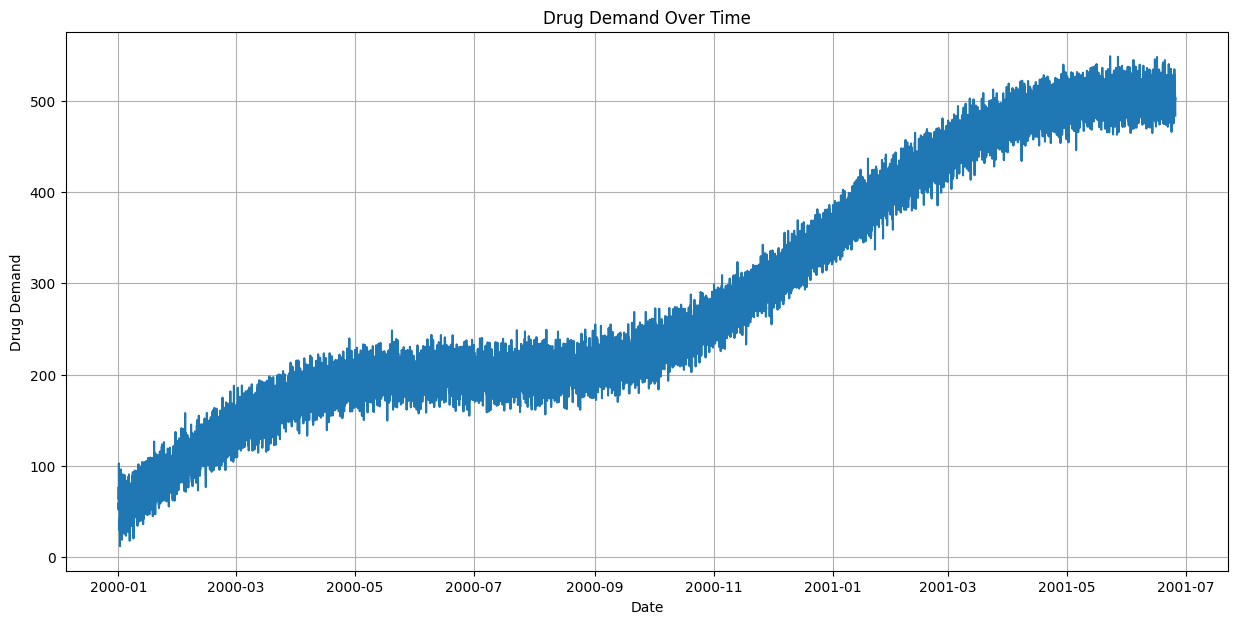

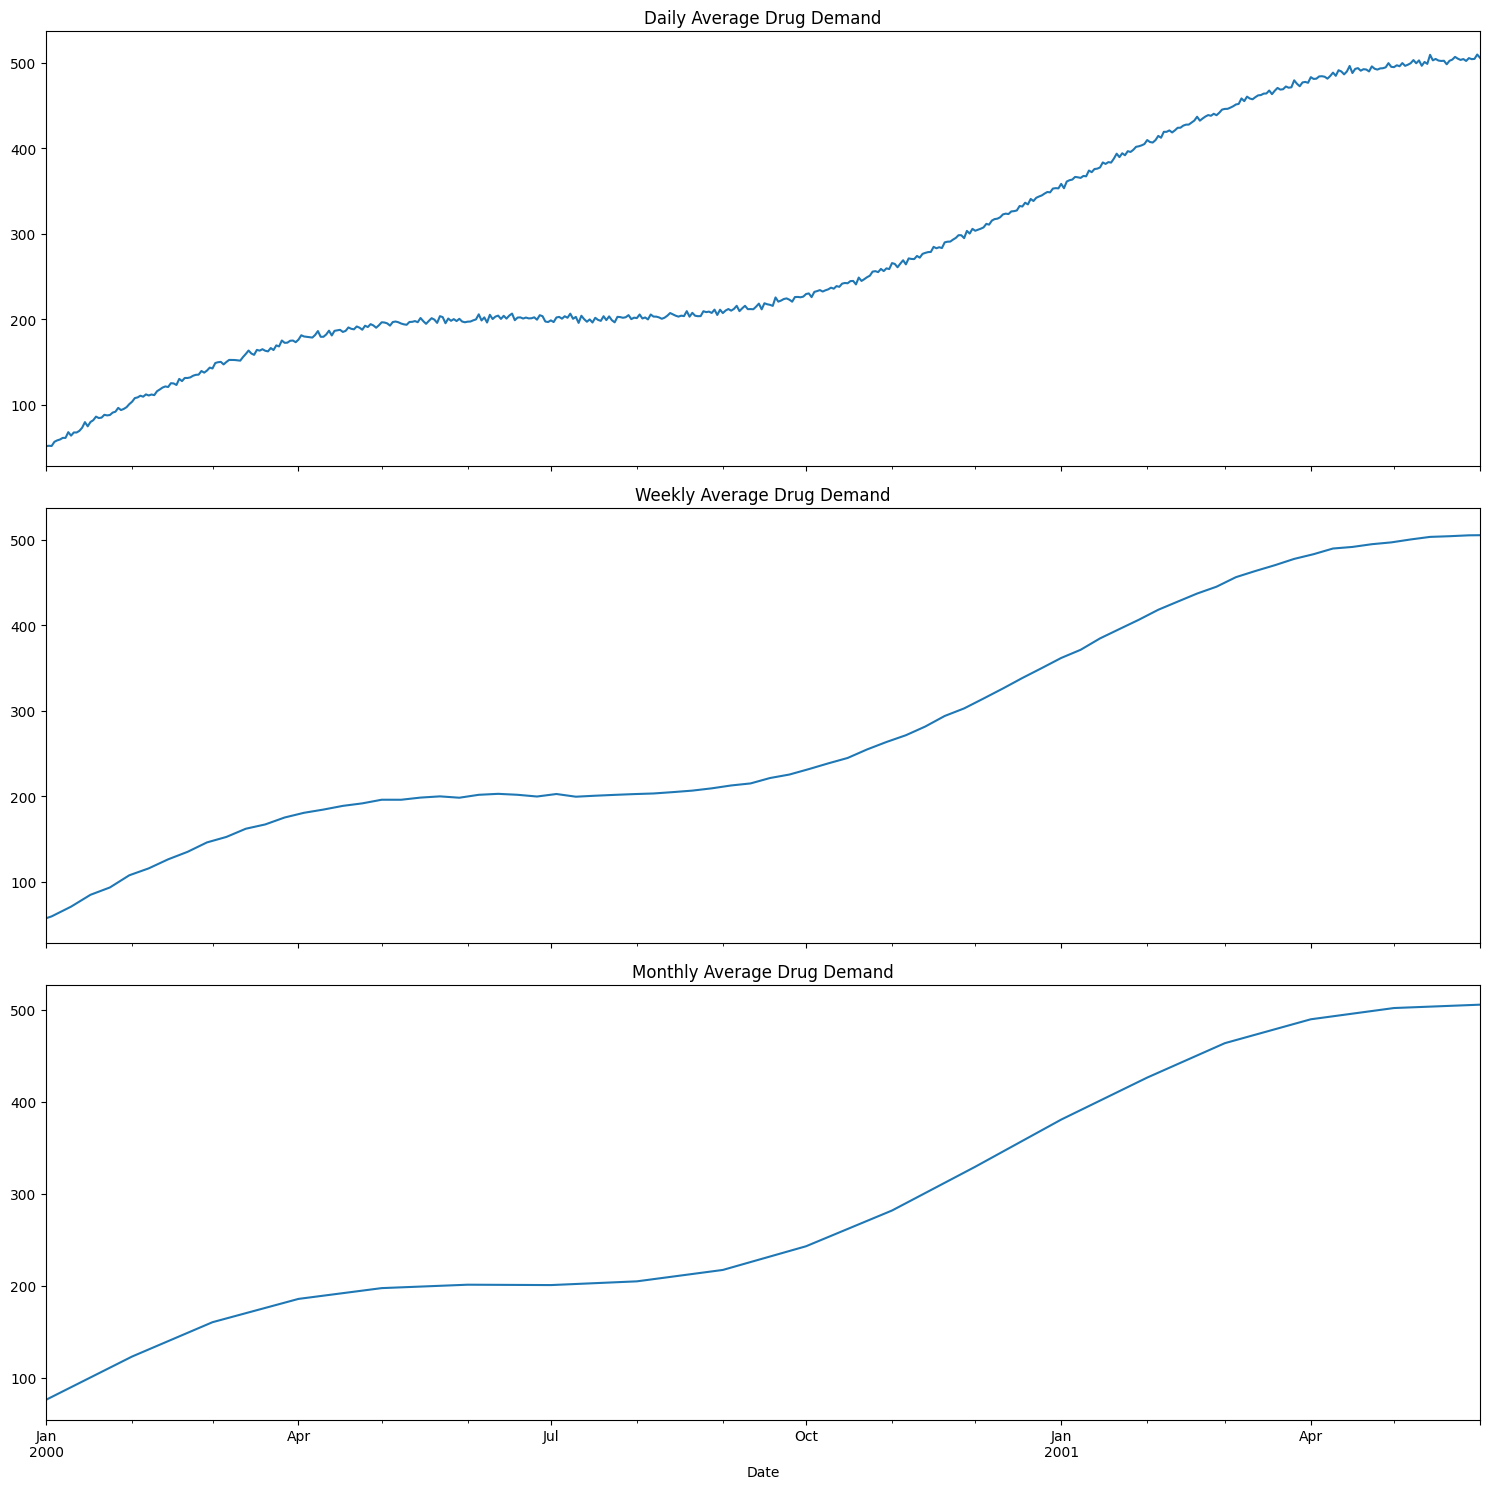

In [36]:
# Plot the time series data
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Drug_Demand'])
plt.title('Drug Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Drug Demand')
plt.grid(True)
plt.show()

# Plot daily, weekly, and monthly patterns
# Resample to daily, weekly, and monthly frequencies
daily_data = df['Drug_Demand'].resample('D').mean()
weekly_data = df['Drug_Demand'].resample('W').mean()
monthly_data = df['Drug_Demand'].resample('M').mean()

# Plot the resampled data
fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

daily_data.plot(ax=axes[0], title='Daily Average Drug Demand')
weekly_data.plot(ax=axes[1], title='Weekly Average Drug Demand')
monthly_data.plot(ax=axes[2], title='Monthly Average Drug Demand')

plt.tight_layout()
plt.show()


# 3- Basic Feature Engineering

In [37]:
# Create time-based features
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df['Month'] = df.index.month
df['Year'] = df.index.year

# Create lag features
df['Demand_Lag1'] = df['Drug_Demand'].shift(1)
df['Demand_Lag24'] = df['Drug_Demand'].shift(24)  # Previous day same hour
df['Demand_Lag168'] = df['Drug_Demand'].shift(168)  # Previous week same hour

# Create rolling window features
df['Rolling_Mean_24h'] = df['Drug_Demand'].rolling(window=24).mean()
df['Rolling_Std_24h'] = df['Drug_Demand'].rolling(window=24).std()

# Drop NaN values
df_clean = df.dropna()

print("Dataset with engineered features:")
print(df_clean.head())


Dataset with engineered features:
                     Drug_Demand  Hour  Weekday  Month  Year  Holiday  \
Date                                                                    
2000-01-08 00:00:00    57.181376     0        5      1  2000        0   
2000-01-08 01:00:00    65.286012     1        5      1  2000        0   
2000-01-08 02:00:00    64.587499     2        5      1  2000        0   
2000-01-08 03:00:00    67.511552     3        5      1  2000        0   
2000-01-08 04:00:00    89.150483     4        5      1  2000        0   

                     Marketing_Spend  Competitor_Price  Day  Demand_Lag1  \
Date                                                                       
2000-01-08 00:00:00      2347.617713         10.619638    8    56.933043   
2000-01-08 01:00:00      4401.303605         21.857900    8    57.181376   
2000-01-08 02:00:00      4503.553890         12.951751    8    65.286012   
2000-01-08 03:00:00      4738.874553         17.715897    8    64.587499  

# 4- Time Series as Supervised Learning 

In [38]:
# Create a function to convert time series to supervised learning format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Convert time series data to supervised learning format.
    
    Parameters:
    data: DataFrame or Series containing the time series
    n_in: Number of lag observations as input (X)
    n_out: Number of observations as output (y)
    dropnan: Boolean whether to drop rows with NaN values
    
    Returns:
    DataFrame of series framed for supervised learning
    """
    n_vars = 1 if isinstance(data, pd.Series) else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

# Apply to our dataset - using Drug_Demand as the target variable
# Create a dataset with 24 hours of history to predict the next hour
supervised_data = series_to_supervised(df[['Drug_Demand']], n_in=24, n_out=1)
print("Supervised Learning Format:")
print(supervised_data.head())


Supervised Learning Format:
                     var1(t-24)  var1(t-23)  var1(t-22)  var1(t-21)  \
Date                                                                  
2000-01-02 00:00:00   58.250988   51.794936   66.562773   76.767008   
2000-01-02 01:00:00   51.794936   66.562773   76.767008   63.255268   
2000-01-02 02:00:00   66.562773   76.767008   63.255268  102.581559   
2000-01-02 03:00:00   76.767008   63.255268  102.581559   85.264165   
2000-01-02 04:00:00   63.255268  102.581559   85.264165   73.146044   

                     var1(t-20)  var1(t-19)  var1(t-18)  var1(t-17)  \
Date                                                                  
2000-01-02 00:00:00   63.255268  102.581559   85.264165   73.146044   
2000-01-02 01:00:00  102.581559   85.264165   73.146044   66.640255   
2000-01-02 02:00:00   85.264165   73.146044   66.640255   59.761167   
2000-01-02 03:00:00   73.146044   66.640255   59.761167   77.819548   
2000-01-02 04:00:00   66.640255   59.761167   77

# 5- Moving Average Smoothing

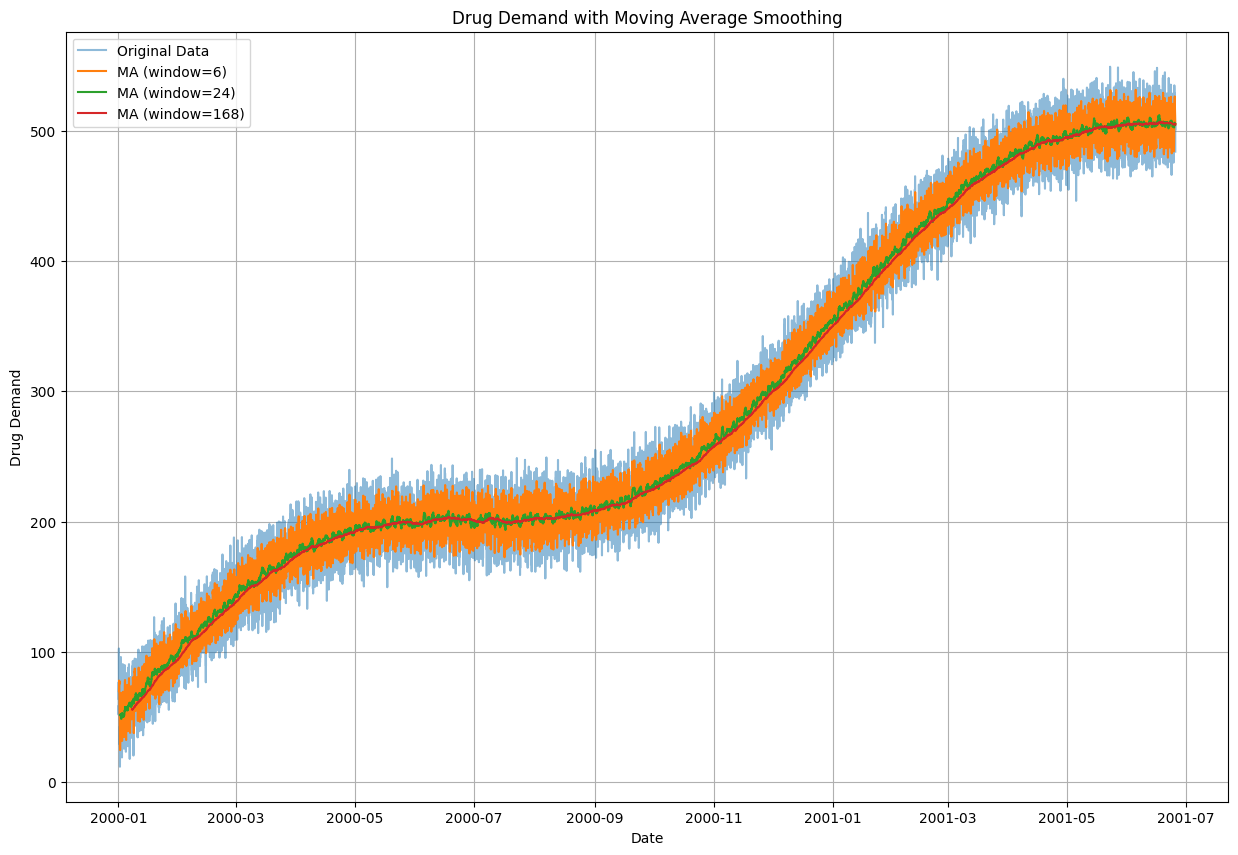

In [39]:
# Calculate moving averages with different window sizes
windows = [6, 24, 168]  # 6 hours, 24 hours (1 day), 168 hours (1 week)
plt.figure(figsize=(15, 10))

# Plot original data
plt.plot(df.index, df['Drug_Demand'], label='Original Data', alpha=0.5)

# Plot moving averages
for window in windows:
    rolling_mean = df['Drug_Demand'].rolling(window=window).mean()
    plt.plot(df.index, rolling_mean, label=f'MA (window={window})')

plt.title('Drug Demand with Moving Average Smoothing')
plt.xlabel('Date')
plt.ylabel('Drug Demand')
plt.legend()
plt.grid(True)
plt.show()


# 6- Power Transforms

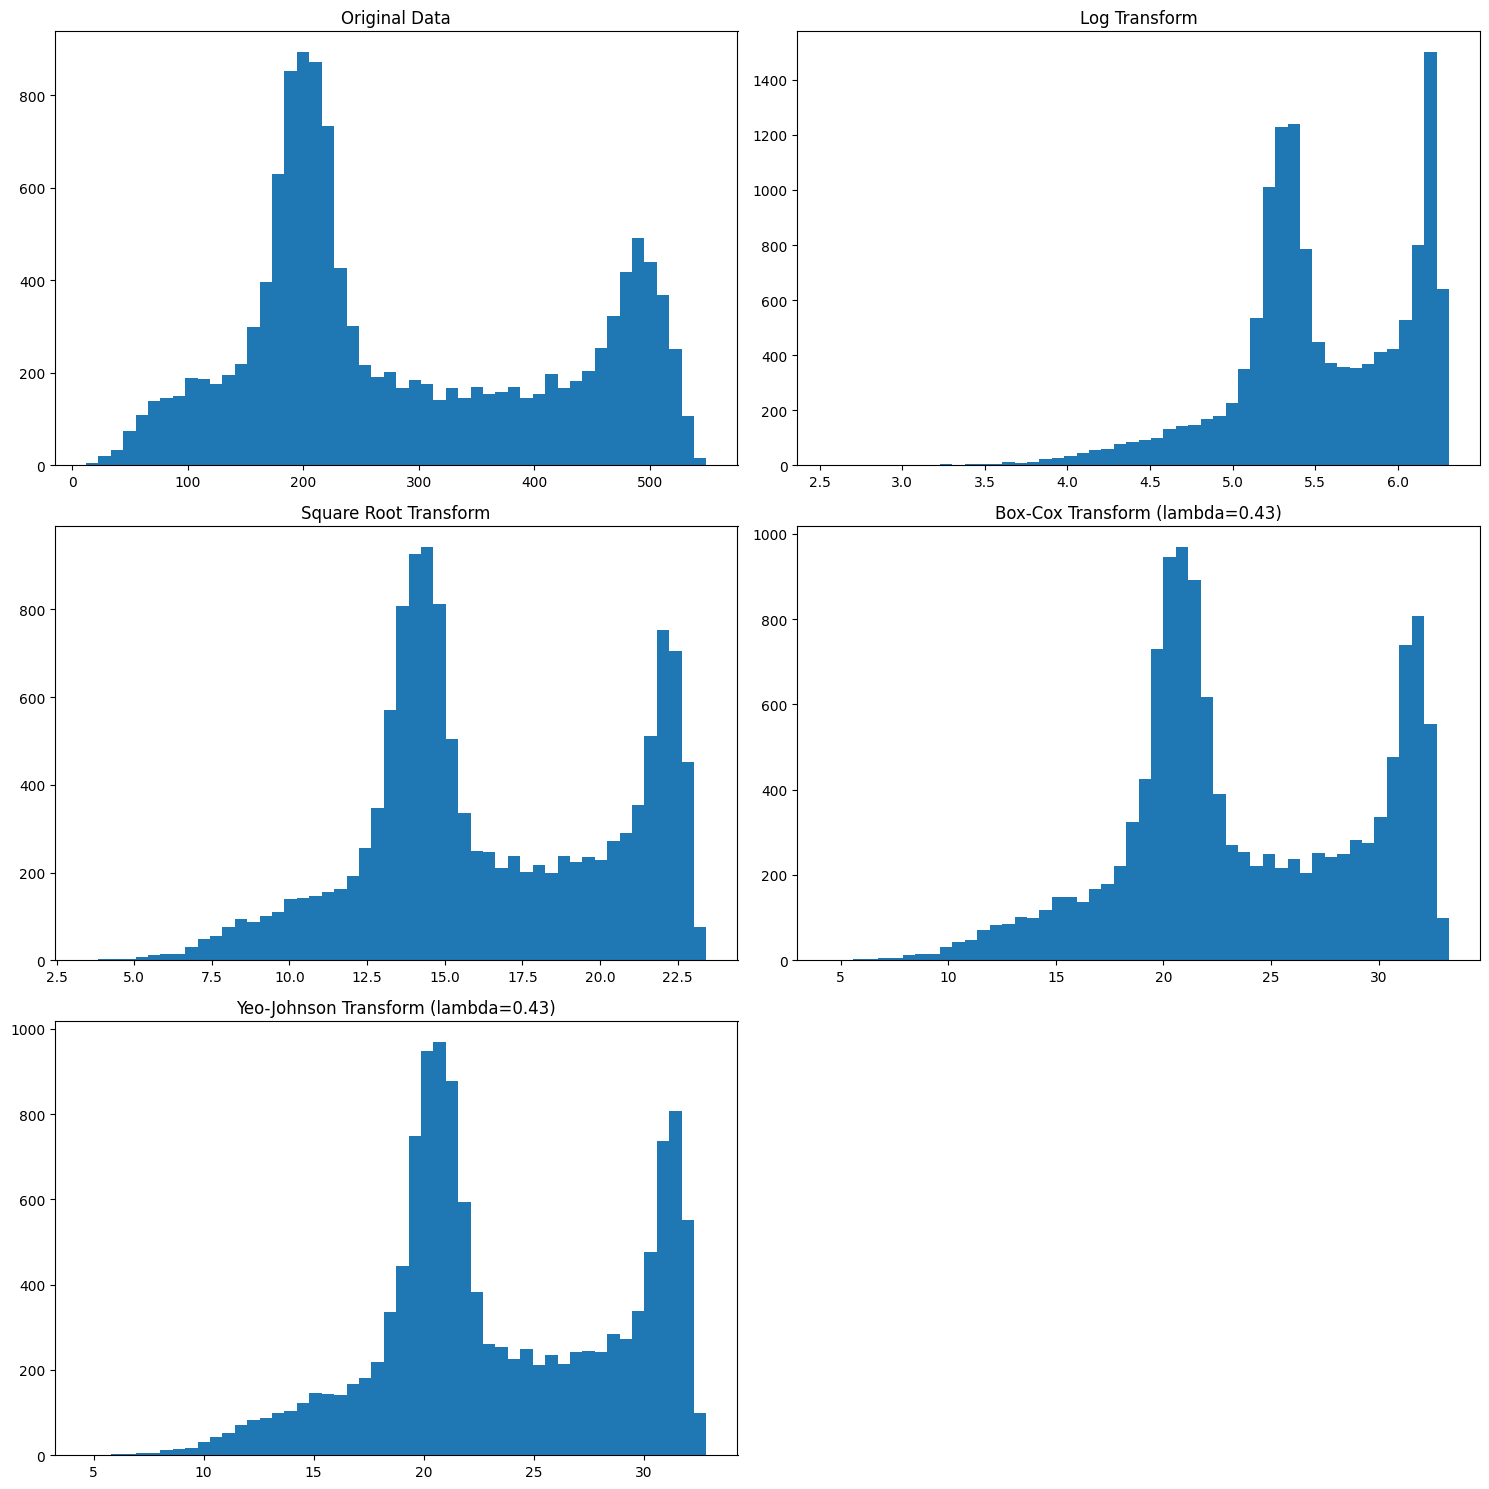

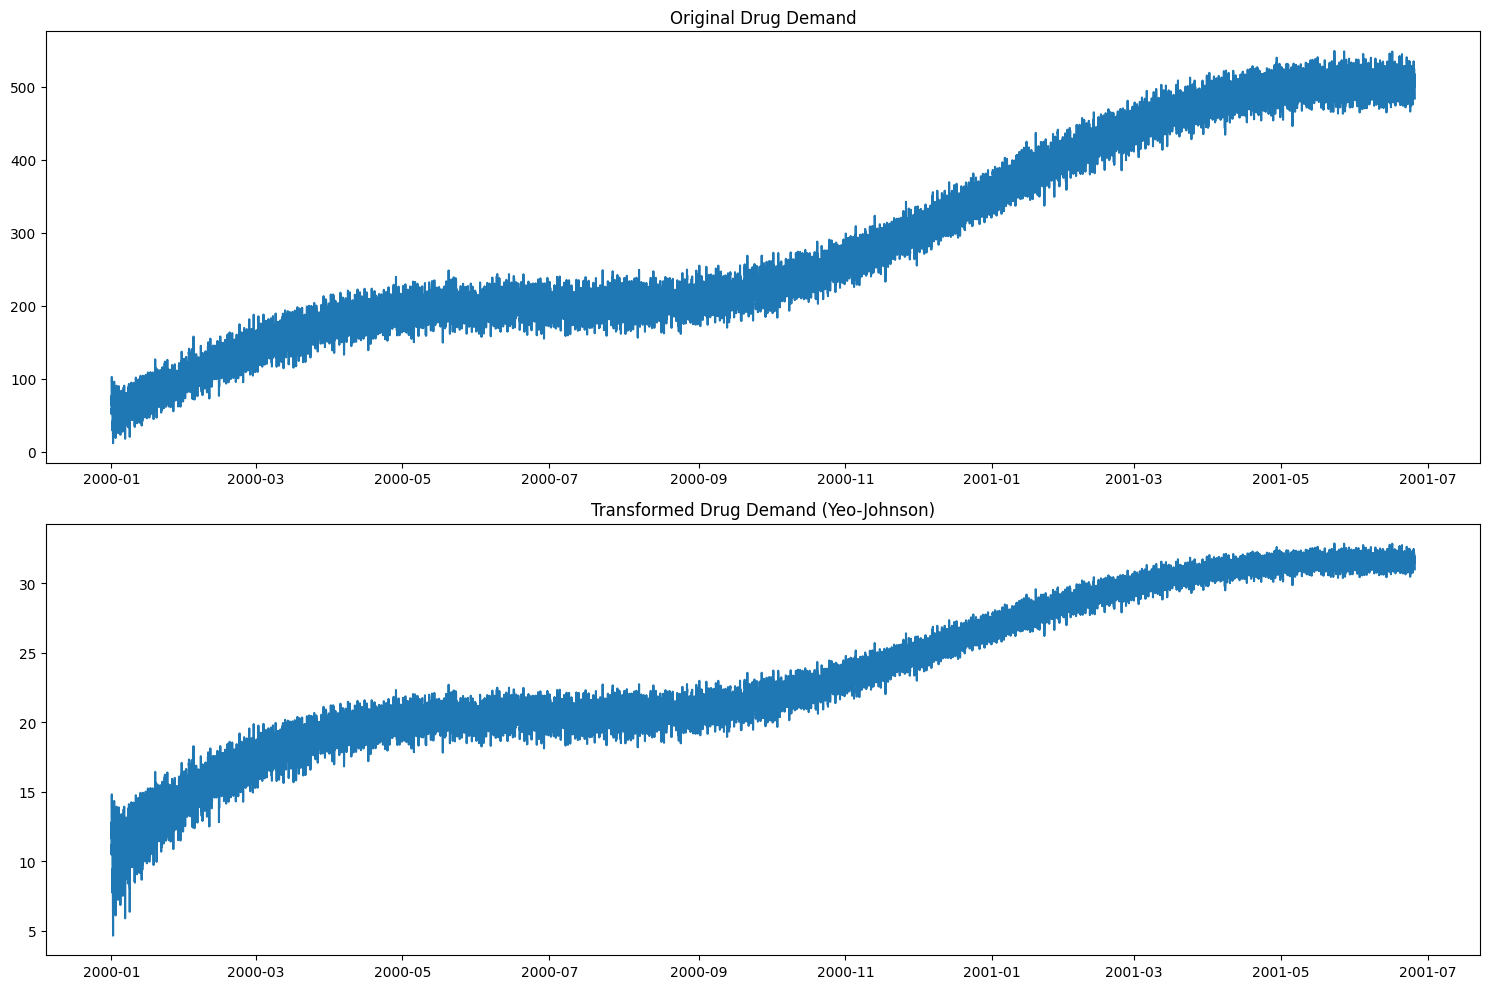

In [40]:
from scipy import stats
import numpy as np

# Apply different power transforms
plt.figure(figsize=(15, 15))

# Original data
plt.subplot(3, 2, 1)
plt.hist(df['Drug_Demand'], bins=50)
plt.title('Original Data')

# Log transform
plt.subplot(3, 2, 2)
log_data = np.log1p(df['Drug_Demand'])  # log1p to handle zeros
plt.hist(log_data, bins=50)
plt.title('Log Transform')

# Square root transform
plt.subplot(3, 2, 3)
sqrt_data = np.sqrt(df['Drug_Demand'])
plt.hist(sqrt_data, bins=50)
plt.title('Square Root Transform')

# Box-Cox transform
plt.subplot(3, 2, 4)
# Add a small constant to ensure all values are positive
drug_demand_pos = df['Drug_Demand'] + 1e-8
boxcox_data, lambda_value = stats.boxcox(drug_demand_pos)
plt.hist(boxcox_data, bins=50)
plt.title(f'Box-Cox Transform (lambda={lambda_value:.2f})')

# Yeo-Johnson transform
plt.subplot(3, 2, 5)
yj_data, lambda_value = stats.yeojohnson(df['Drug_Demand'])
plt.hist(yj_data, bins=50)
plt.title(f'Yeo-Johnson Transform (lambda={lambda_value:.2f})')

plt.tight_layout()
plt.show()

# Compare original and transformed time series
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Drug_Demand'])
plt.title('Original Drug Demand')

plt.subplot(2, 1, 2)
plt.plot(df.index, yj_data)  # Using Yeo-Johnson as an example
plt.title('Transformed Drug Demand (Yeo-Johnson)')

plt.tight_layout()
plt.show()


# 7- Decompose Time Series Data

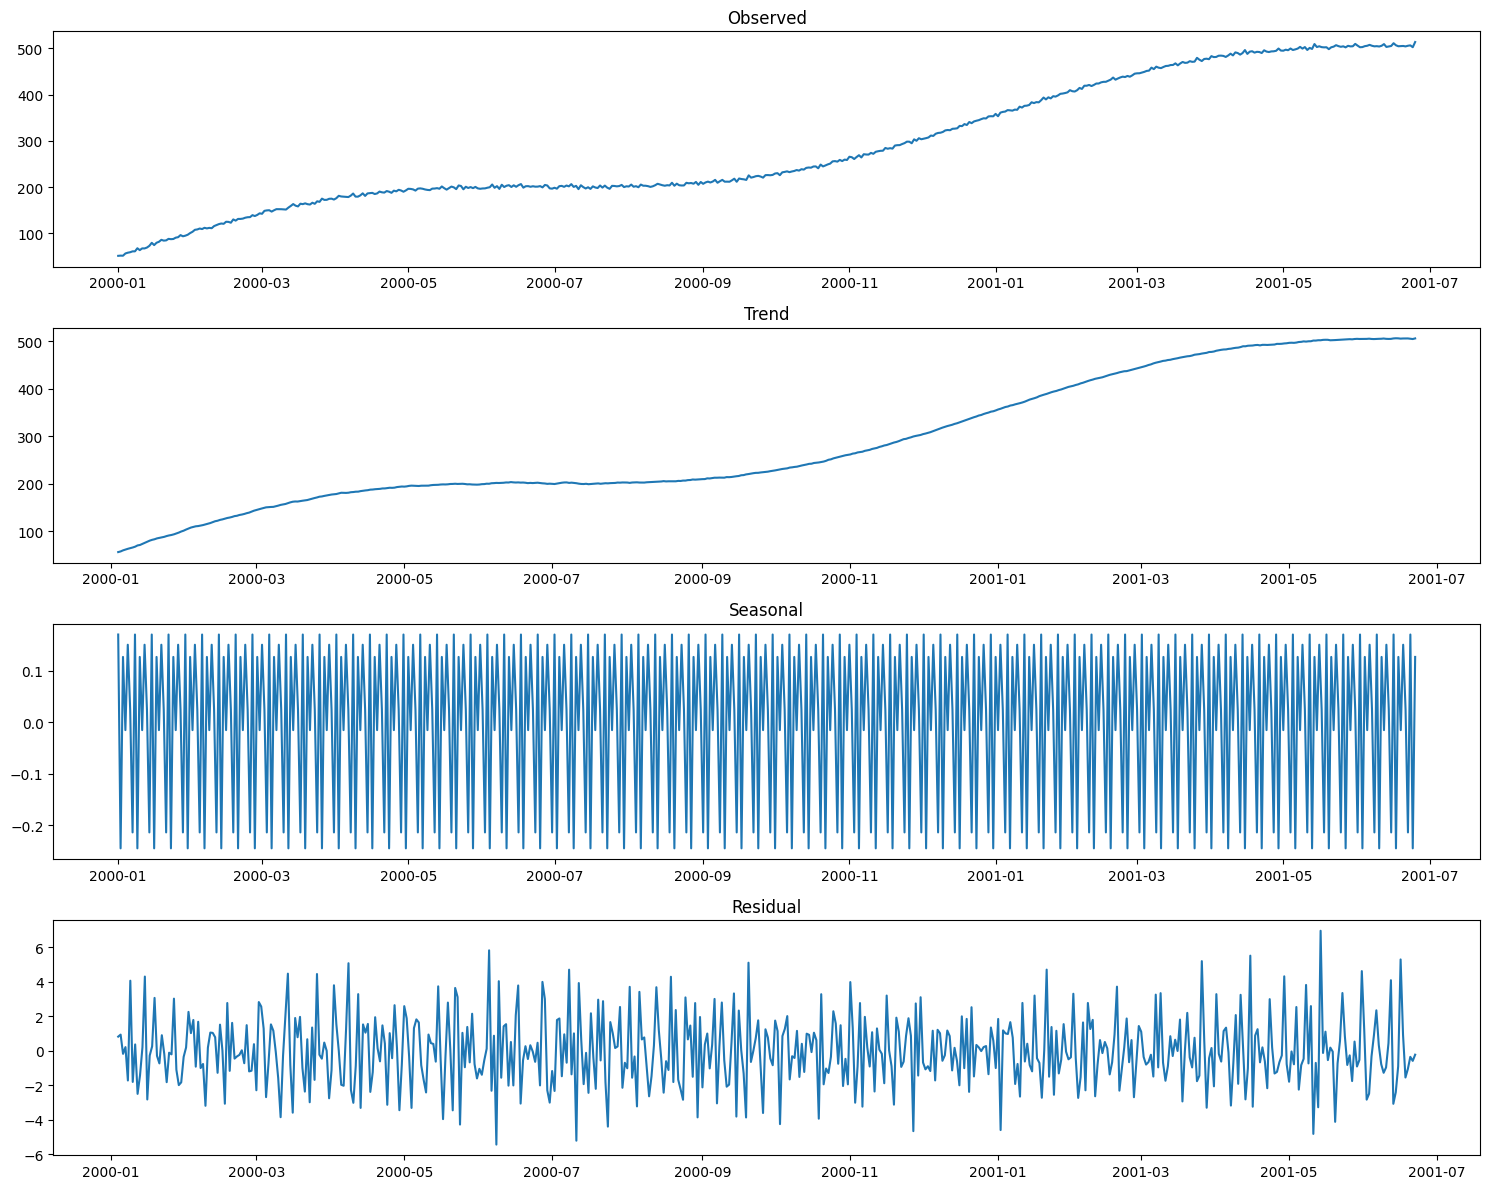

In [41]:
# Resample to daily data for decomposition
daily_demand = df['Drug_Demand'].resample('D').mean()

# Fill missing values if any
daily_demand = daily_demand.fillna(method='ffill')

# Decompose the time series
decomposition = seasonal_decompose(daily_demand, model='additive', period=7)  # Weekly seasonality

# Plot the decomposition
plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()


# 8- Use and Remove Trends

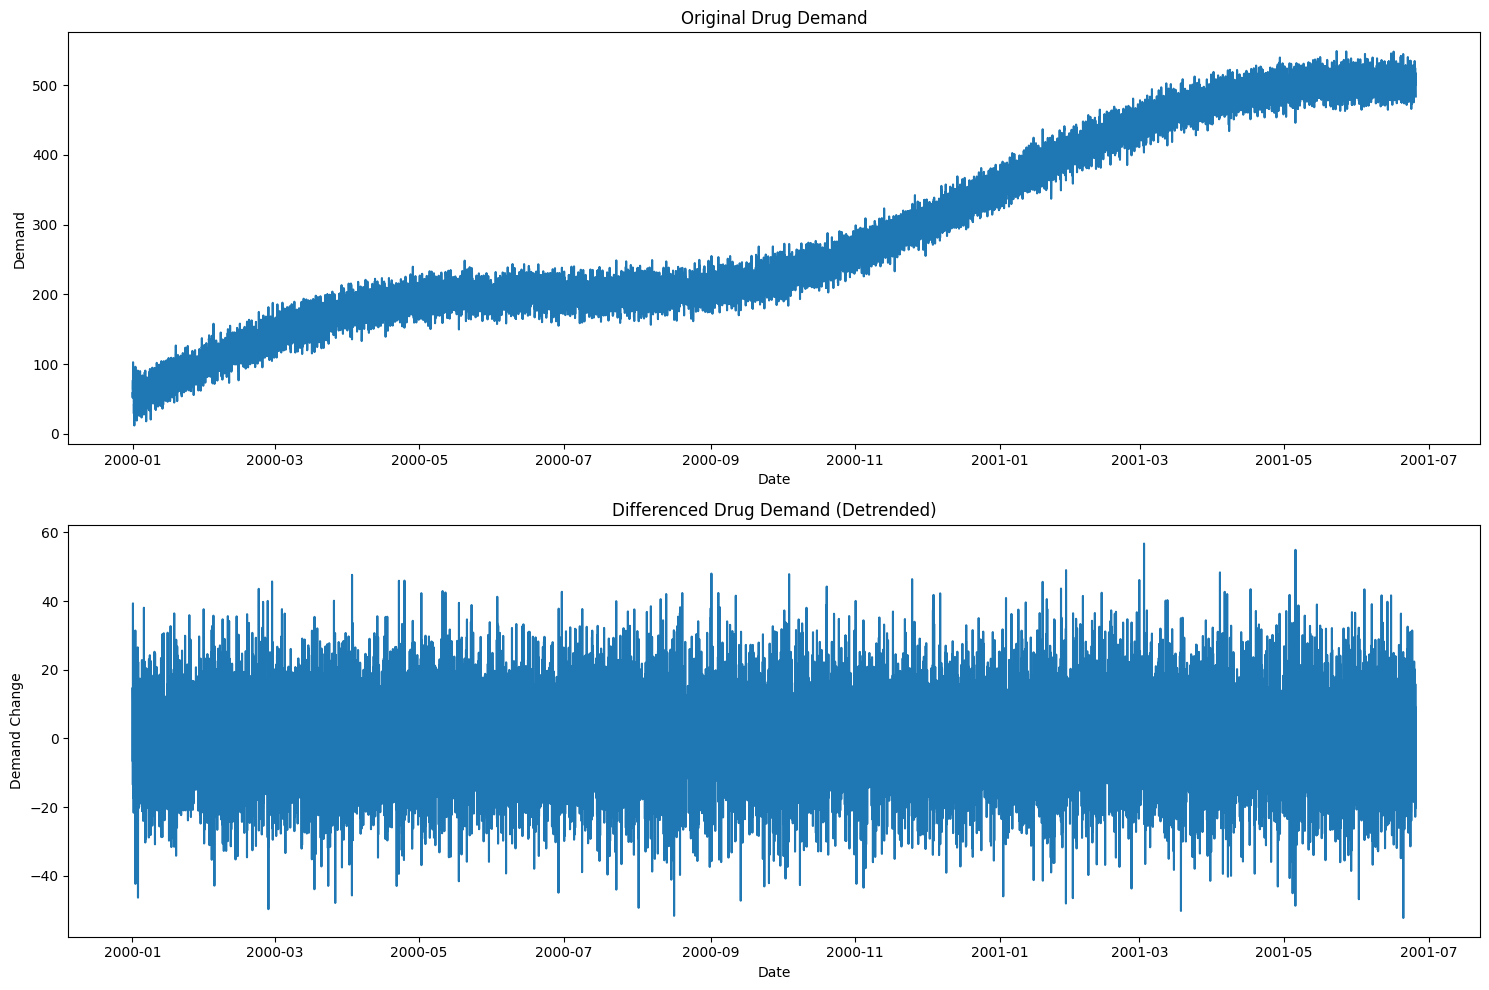

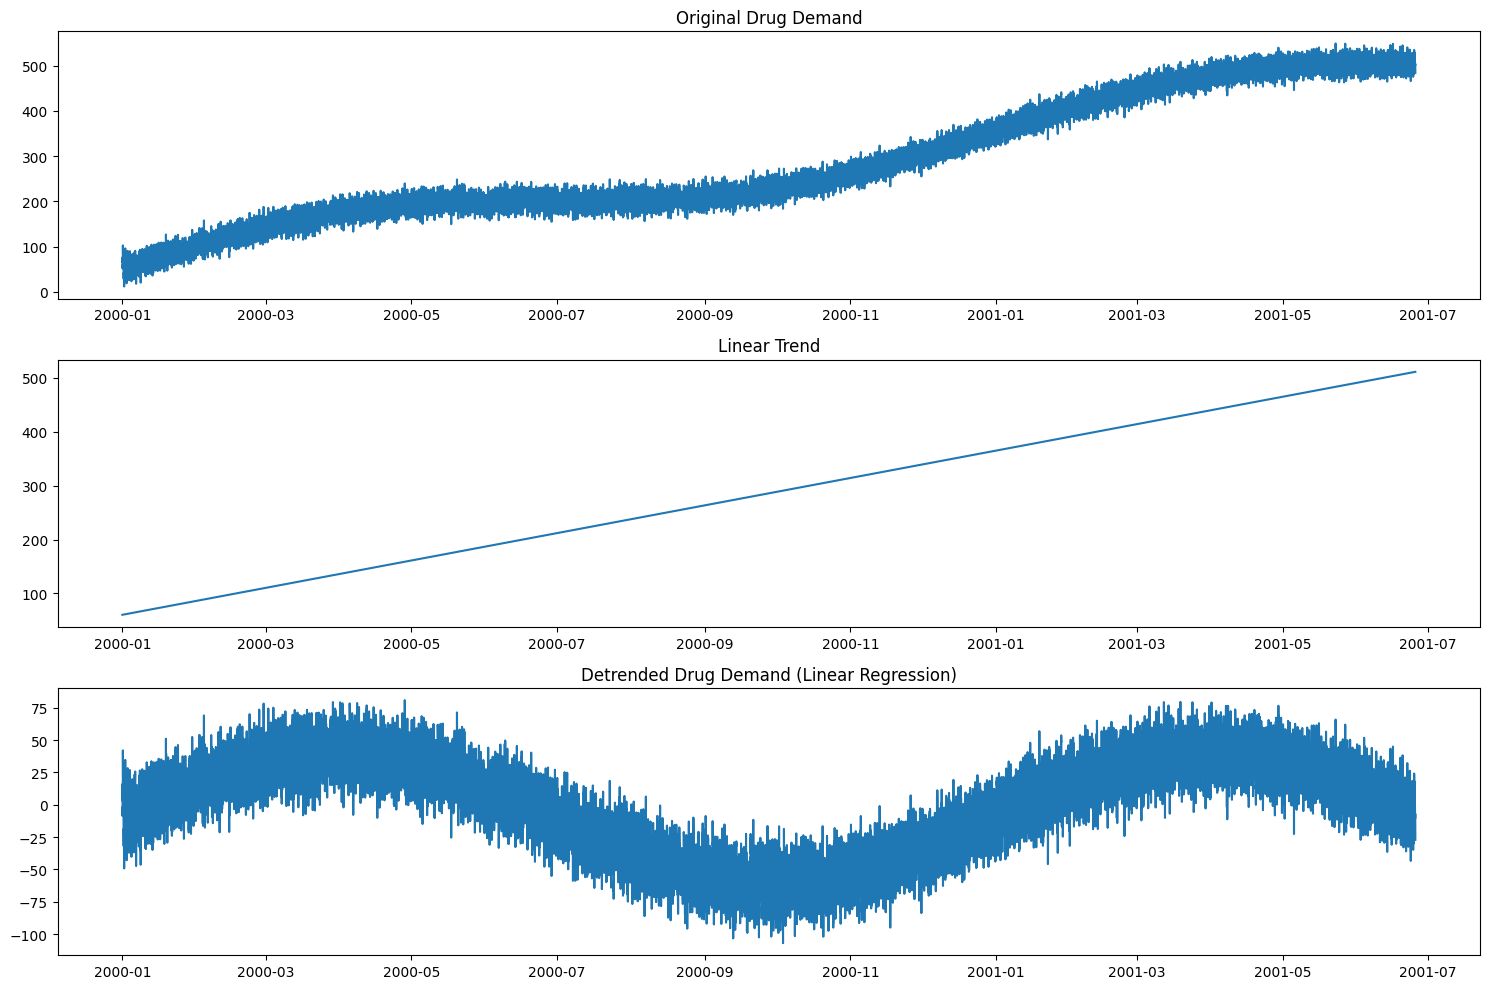

In [42]:
# Detrending using differencing
df['Drug_Demand_Diff'] = df['Drug_Demand'].diff()

# Plot original vs differenced data
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df.index, df['Drug_Demand'])
plt.title('Original Drug Demand')
plt.xlabel('Date')
plt.ylabel('Demand')

plt.subplot(2, 1, 2)
plt.plot(df.index, df['Drug_Demand_Diff'])
plt.title('Differenced Drug Demand (Detrended)')
plt.xlabel('Date')
plt.ylabel('Demand Change')

plt.tight_layout()
plt.show()

# Detrending using regression
from sklearn.linear_model import LinearRegression

# Create a time index
df['Time_Index'] = np.arange(len(df))

# Fit a linear trend
X = df['Time_Index'].values.reshape(-1, 1)
y = df['Drug_Demand'].values
model = LinearRegression()
model.fit(X, y)

# Get the trend and detrended data
trend = model.predict(X)
detrended = df['Drug_Demand'] - trend

# Plot the results
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df.index, df['Drug_Demand'])
plt.title('Original Drug Demand')

plt.subplot(3, 1, 2)
plt.plot(df.index, trend)
plt.title('Linear Trend')

plt.subplot(3, 1, 3)
plt.plot(df.index, detrended)
plt.title('Detrended Drug Demand (Linear Regression)')

plt.tight_layout()
plt.show()


# 9-  Use and Remove Seasonality

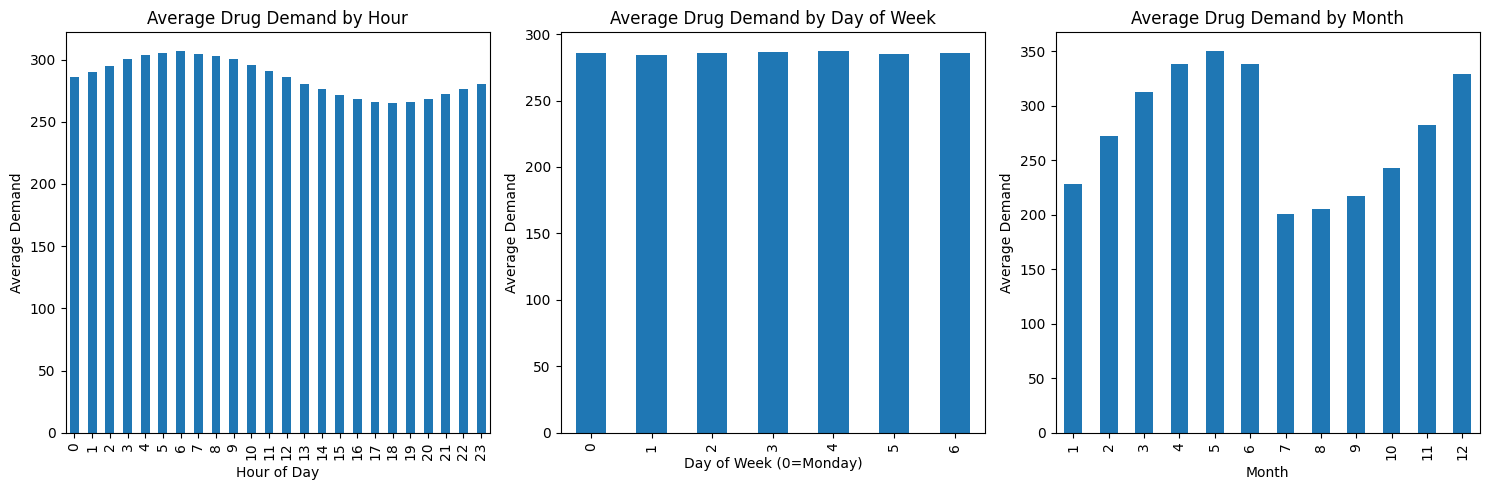

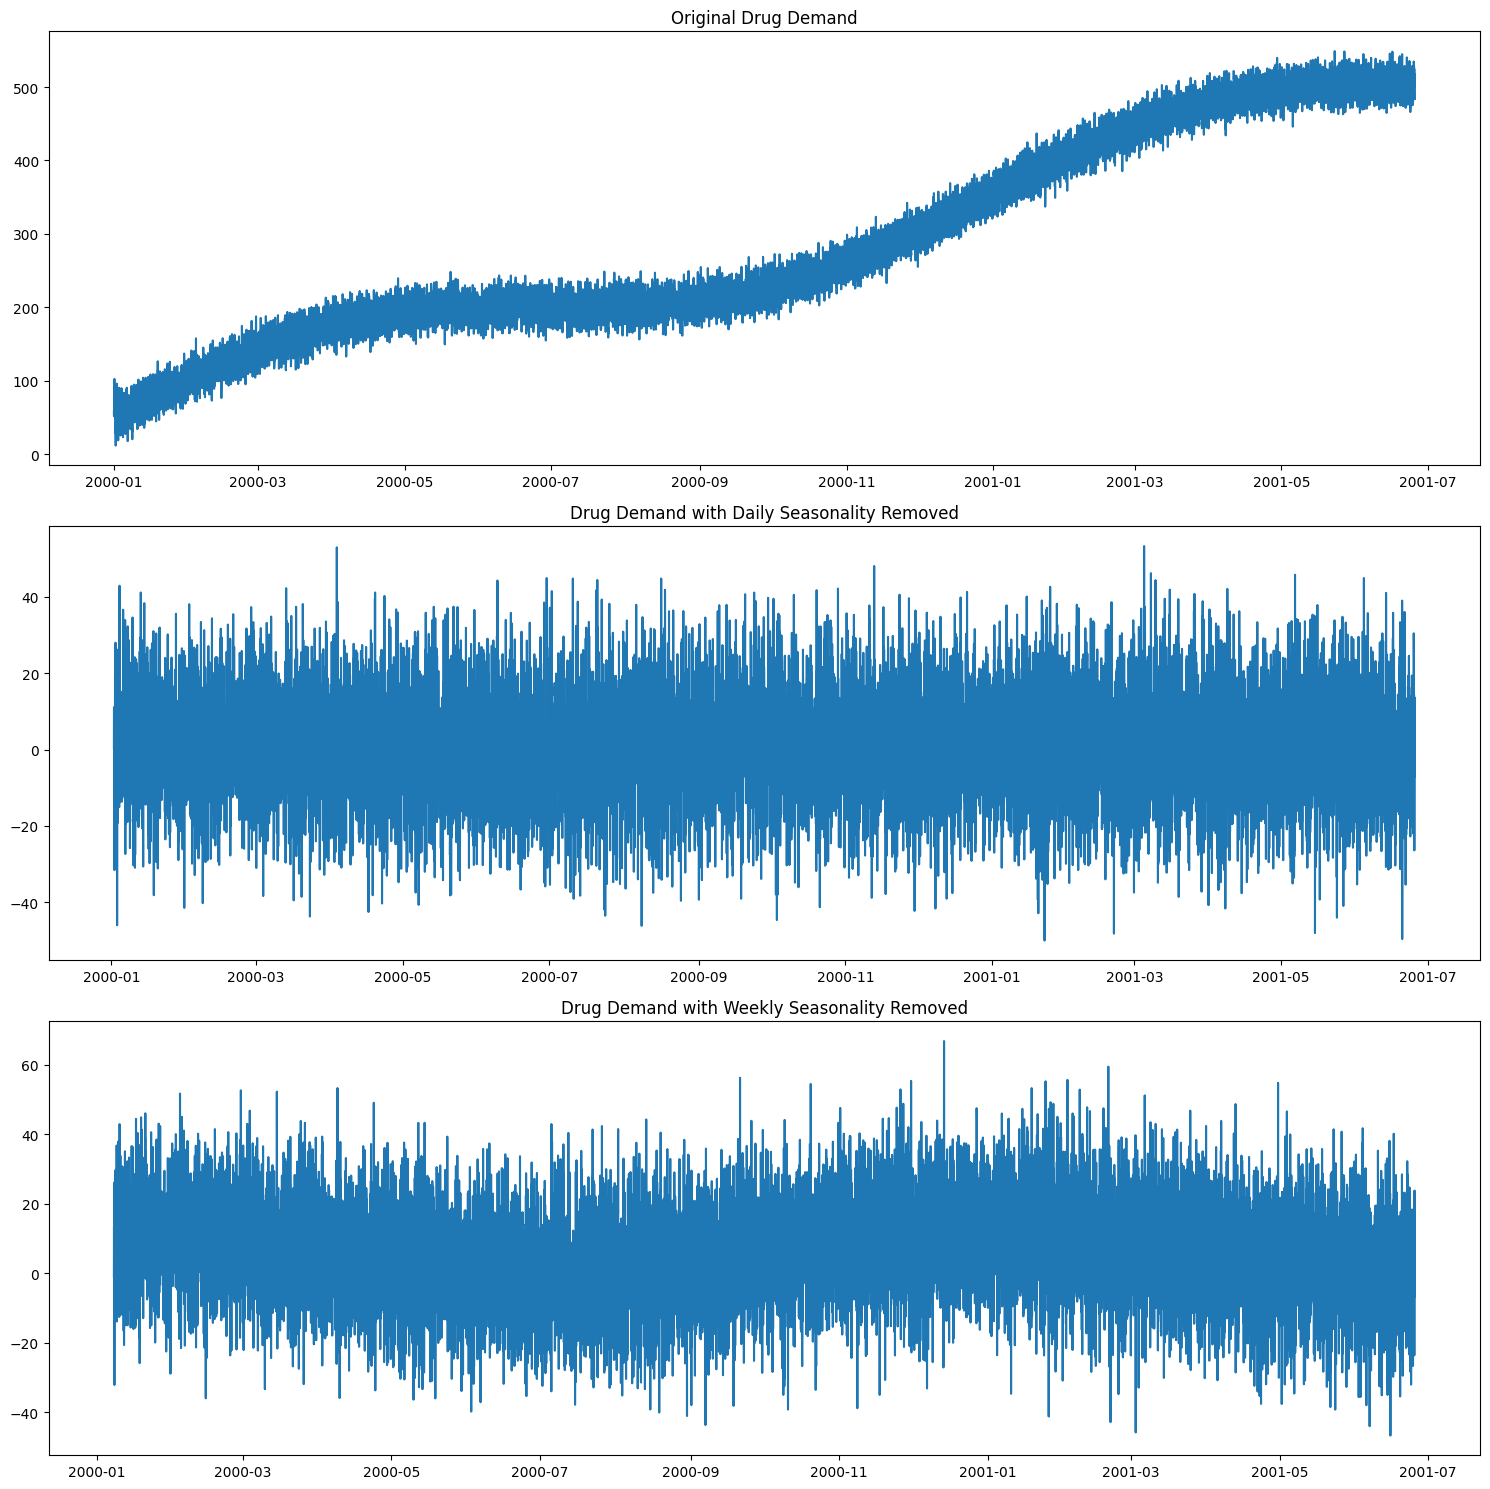

In [43]:
# Analyze hourly, daily, and weekly seasonality
# Hourly patterns
hourly_avg = df.groupby(df.index.hour)['Drug_Demand'].mean()
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
hourly_avg.plot(kind='bar')
plt.title('Average Drug Demand by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Demand')

# Daily patterns
daily_avg = df.groupby(df.index.weekday)['Drug_Demand'].mean()
plt.subplot(1, 3, 2)
daily_avg.plot(kind='bar')
plt.title('Average Drug Demand by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Average Demand')

# Monthly patterns
monthly_avg = df.groupby(df.index.month)['Drug_Demand'].mean()
plt.subplot(1, 3, 3)
monthly_avg.plot(kind='bar')
plt.title('Average Drug Demand by Month')
plt.xlabel('Month')
plt.ylabel('Average Demand')

plt.tight_layout()
plt.show()

# Remove seasonality using seasonal differencing
# Daily seasonality (24 hours)
df['Drug_Demand_Seasonal_Diff_24'] = df['Drug_Demand'].diff(24)

# Weekly seasonality (168 hours)
df['Drug_Demand_Seasonal_Diff_168'] = df['Drug_Demand'].diff(168)

# Plot the results
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(df.index, df['Drug_Demand'])
plt.title('Original Drug Demand')

plt.subplot(3, 1, 2)
plt.plot(df.index, df['Drug_Demand_Seasonal_Diff_24'])
plt.title('Drug Demand with Daily Seasonality Removed')

plt.subplot(3, 1, 3)
plt.plot(df.index, df['Drug_Demand_Seasonal_Diff_168'])
plt.title('Drug Demand with Weekly Seasonality Removed')

plt.tight_layout()
plt.show()


# 10- Stationarity in Time Series Data

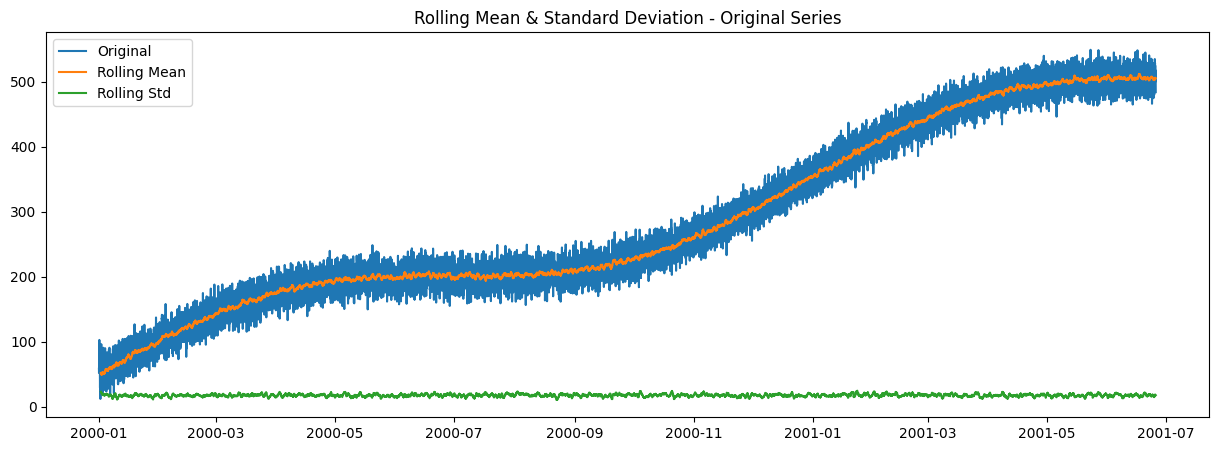

Results of Dickey-Fuller Test for Original Series:
Test Statistic                    -0.609948
p-value                            0.868718
#Lags Used                        41.000000
Number of Observations Used    12958.000000
Critical Value (1%)               -3.430855
Critical Value (5%)               -2.861763
Critical Value (10%)              -2.566889
dtype: float64
Conclusion: The series is non-stationary (fail to reject the null hypothesis)




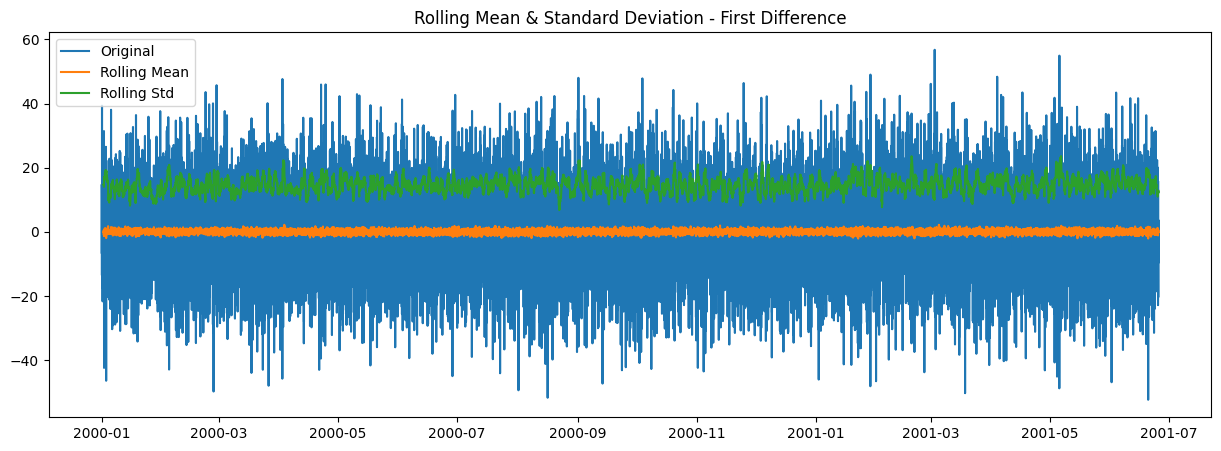

Results of Dickey-Fuller Test for First Difference:
Test Statistic                   -26.939215
p-value                            0.000000
#Lags Used                        41.000000
Number of Observations Used    12957.000000
Critical Value (1%)               -3.430855
Critical Value (5%)               -2.861763
Critical Value (10%)              -2.566889
dtype: float64
Conclusion: The series is stationary (reject the null hypothesis)




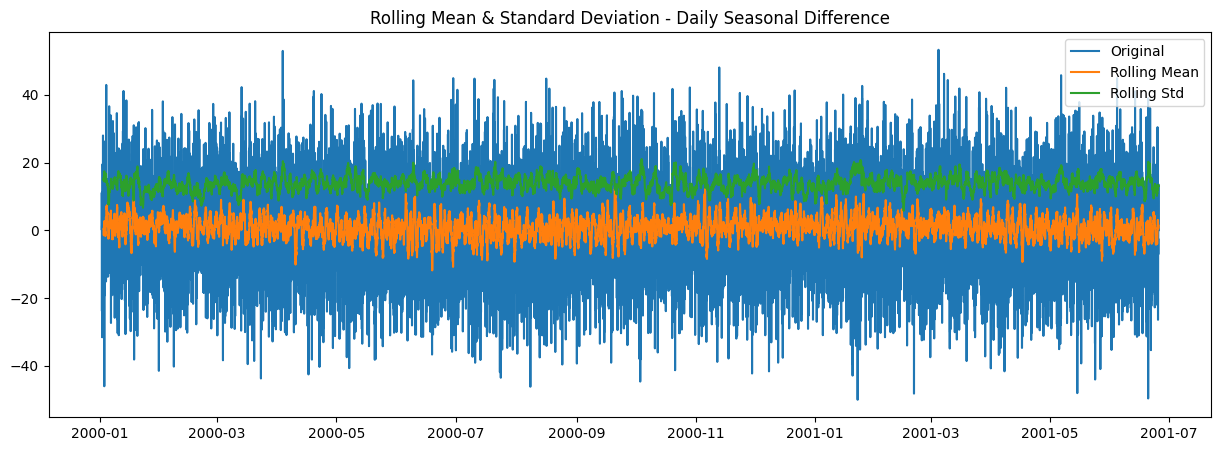

Results of Dickey-Fuller Test for Daily Seasonal Difference:
Test Statistic                   -28.538737
p-value                            0.000000
#Lags Used                        29.000000
Number of Observations Used    12946.000000
Critical Value (1%)               -3.430855
Critical Value (5%)               -2.861763
Critical Value (10%)              -2.566889
dtype: float64
Conclusion: The series is stationary (reject the null hypothesis)




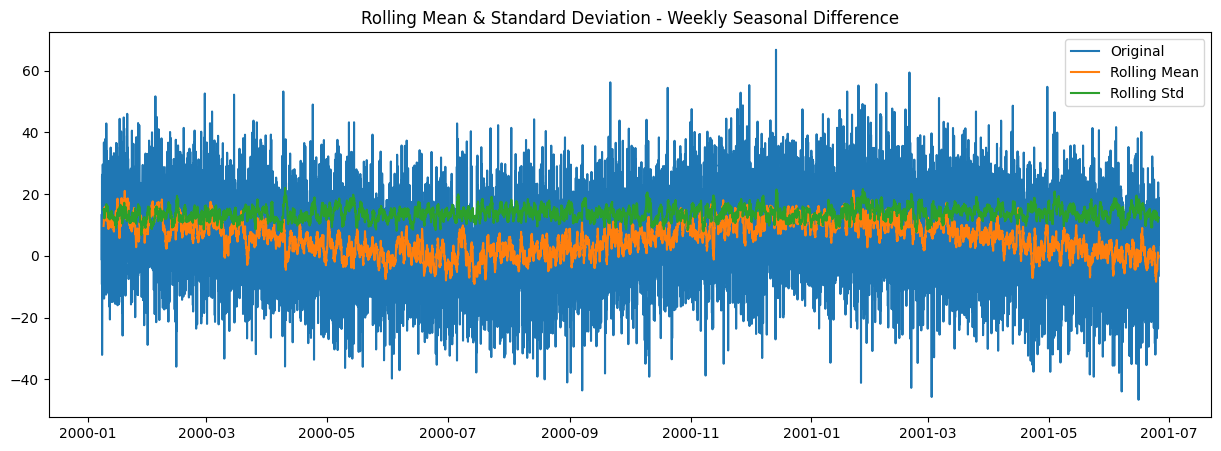

Results of Dickey-Fuller Test for Weekly Seasonal Difference:
Test Statistic                -8.294305e+00
p-value                        4.180075e-13
#Lags Used                     4.100000e+01
Number of Observations Used    1.279000e+04
Critical Value (1%)           -3.430861e+00
Critical Value (5%)           -2.861766e+00
Critical Value (10%)          -2.566890e+00
dtype: float64
Conclusion: The series is stationary (reject the null hypothesis)




In [44]:
# Test for stationarity using Augmented Dickey-Fuller test
def test_stationarity(timeseries, window=24, title=''):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(15, 5))
    plt.plot(timeseries, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.title(f'Rolling Mean & Standard Deviation - {title}')
    plt.show()
    
    # Perform Dickey-Fuller test
    print(f'Results of Dickey-Fuller Test for {title}:')
    dftest = adfuller(timeseries.dropna())
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    # Interpret the results
    if dftest[1] <= 0.05:
        print("Conclusion: The series is stationary (reject the null hypothesis)")
    else:
        print("Conclusion: The series is non-stationary (fail to reject the null hypothesis)")
    print("\n")

# Test original series
test_stationarity(df['Drug_Demand'].dropna(), title='Original Series')

# Test differenced series
test_stationarity(df['Drug_Demand_Diff'].dropna(), title='First Difference')

# Test seasonally differenced series
test_stationarity(df['Drug_Demand_Seasonal_Diff_24'].dropna(), title='Daily Seasonal Difference')
test_stationarity(df['Drug_Demand_Seasonal_Diff_168'].dropna(), title='Weekly Seasonal Difference')


# 11- Backtest Forecast Model

Observations: 13000
Training Observations: 10400
Testing Observations: 2600


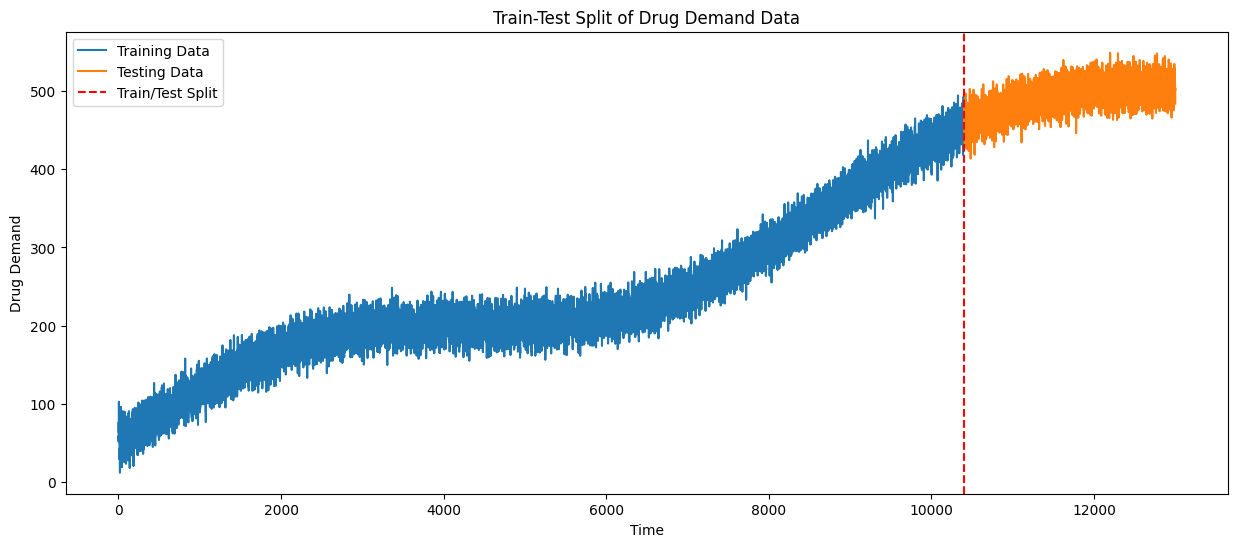

In [45]:
# Split the data into training and testing sets
X = df['Drug_Demand'].values
train_size = int(len(X) * 0.8)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

# Plot the train-test split
plt.figure(figsize=(15, 6))
plt.plot(range(len(train)), train, label='Training Data')
plt.plot(range(len(train), len(X)), test, label='Testing Data')
plt.axvline(x=len(train), color='r', linestyle='--', label='Train/Test Split')
plt.title('Train-Test Split of Drug Demand Data')
plt.xlabel('Time')
plt.ylabel('Drug Demand')
plt.legend()
plt.show()


# 12- Persistence Algorithm & Residual Forecast Errors

Test RMSE: 14.969


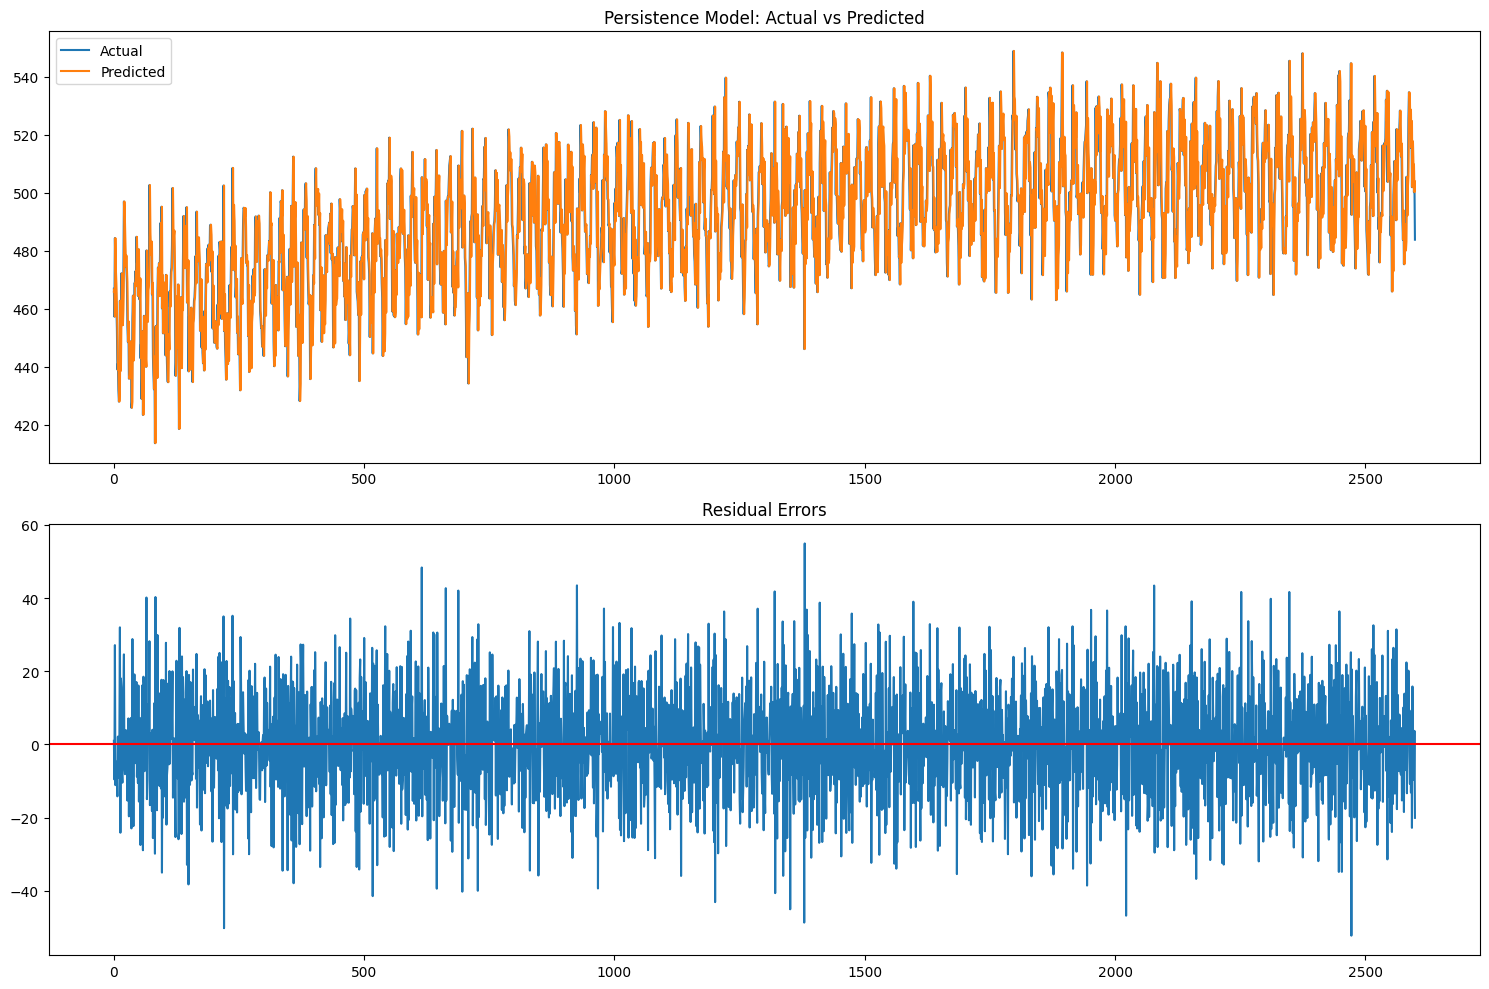

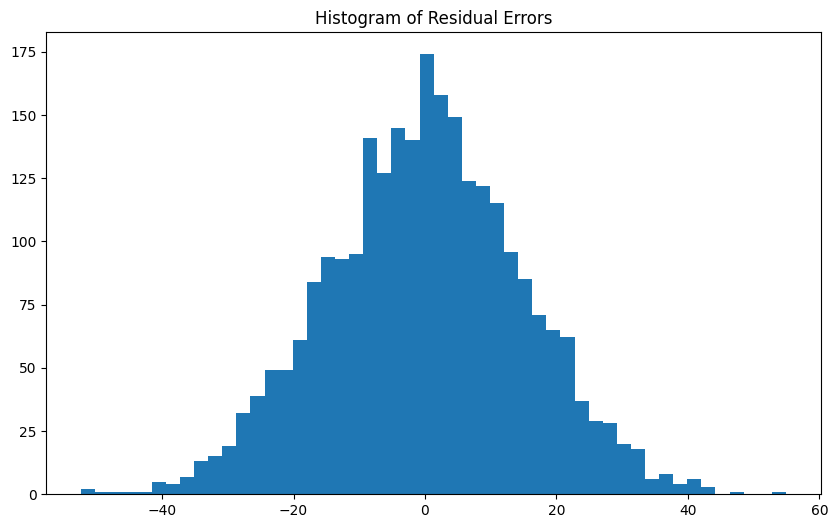

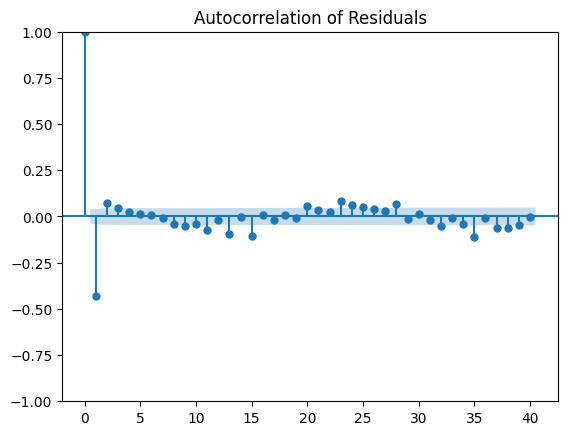

In [46]:
# Create a lagged dataset for the persistence model
df_lag = pd.DataFrame()
df_lag['t'] = df['Drug_Demand'].shift(1)
df_lag['t+1'] = df['Drug_Demand']
df_lag.dropna(inplace=True)

# Split into training and test sets
X = df_lag.values
train_size = int(len(X) * 0.8)
train, test = X[0:train_size], X[train_size:]
train_X, train_y = train[:, 0], train[:, 1]
test_X, test_y = test[:, 0], test[:, 1]

# Persistence model (predict t+1 = t)
def model_persistence(x):
    return x

# Walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

# Calculate residuals
residuals = [test_y[i] - predictions[i] for i in range(len(predictions))]
residuals = pd.Series(residuals)

# Plot the results
plt.figure(figsize=(15, 10))

# Plot actual vs predicted
plt.subplot(2, 1, 1)
plt.plot(test_y, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Persistence Model: Actual vs Predicted')
plt.legend()

# Plot residuals
plt.subplot(2, 1, 2)
plt.plot(residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Errors')

plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50)
plt.title('Histogram of Residual Errors')
plt.show()

# Check if residuals are white noise
plot_acf(residuals, lags=40)
plt.title('Autocorrelation of Residuals')
plt.show()


# 13- Reframe Time Series Forecasting Problems

In [47]:
# Create a multivariate supervised learning dataset
features = ['Drug_Demand', 'Marketing_Spend', 'Competitor_Price', 'Hour', 'Weekday', 'Month', 'Holiday']
mv_df = df[features].copy()

# Create lagged features
for i in range(1, 25):  # Create 24 lags
    mv_df[f'Demand_Lag{i}'] = df['Drug_Demand'].shift(i)

# Drop NaN values
mv_df.dropna(inplace=True)

# Split into X (features) and y (target)
X = mv_df.drop('Drug_Demand', axis=1)
y = mv_df['Drug_Demand']

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Multivariate dataset shape:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Discretize the target variable for classification
def discretize_demand(value):
    if value < df['Drug_Demand'].quantile(0.33):
        return 0  # Low demand
    elif value < df['Drug_Demand'].quantile(0.66):
        return 1  # Medium demand
    else:
        return 2  # High demand

# Create a classification version of the target
y_class = y.apply(discretize_demand)

# Split into train and test sets for classification
y_class_train, y_class_test = y_class[:train_size], y_class[train_size:]

print("\nClass distribution in training set:")
print(y_class_train.value_counts())
print("\nClass distribution in test set:")
print(y_class_test.value_counts())


Multivariate dataset shape:
X_train: (10380, 30), y_train: (10380,)
X_test: (2596, 30), y_test: (2596,)

Class distribution in training set:
Drug_Demand
1    4290
0    4266
2    1824
Name: count, dtype: int64

Class distribution in test set:
Drug_Demand
2    2596
Name: count, dtype: int64


# 14- Autoregression Models for Forecasting

Coefficients: [ 0.35002134  0.1404721   0.10798584  0.1028094   0.08997107  0.06856437
  0.04646739  0.01331681 -0.01478115 -0.02642283 -0.02589824 -0.02426552
 -0.04495565 -0.03605058 -0.02018797 -0.0126795   0.0040719   0.03272409
  0.04389658  0.05944343  0.08131121  0.07788334  0.10038865  0.11173824
  0.12486251]
Test RMSE: 47.204


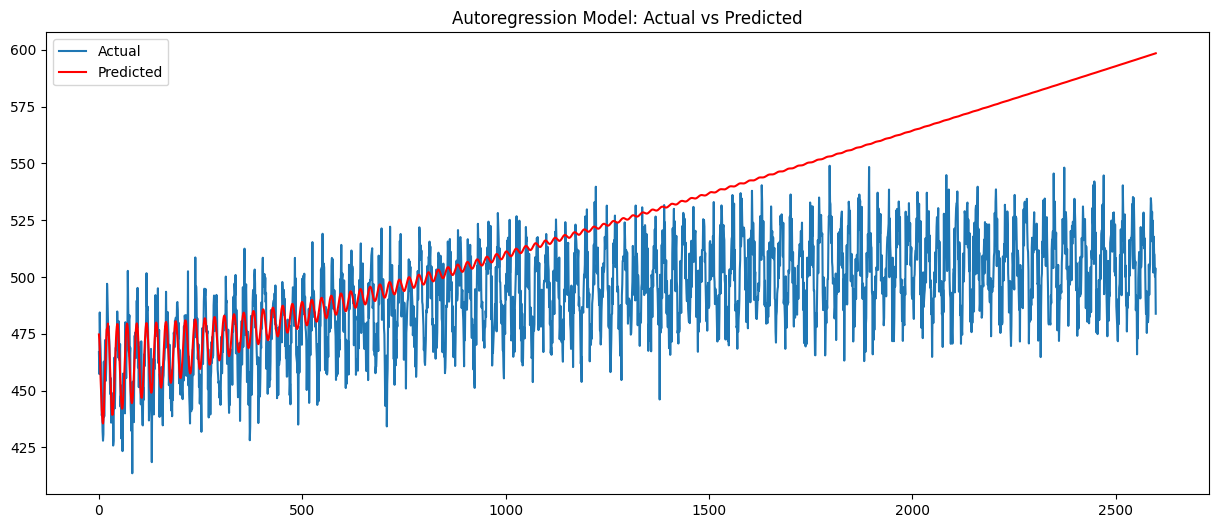

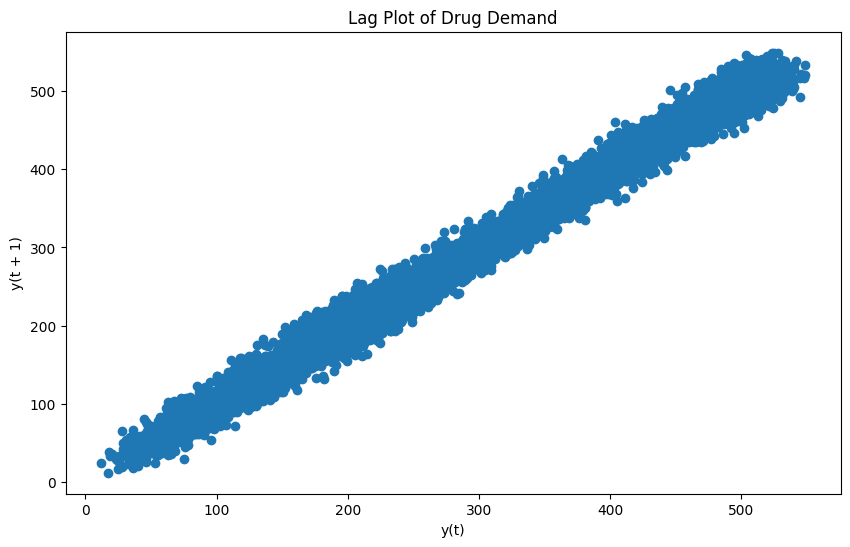

In [48]:
from statsmodels.tsa.ar_model import AutoReg

# Prepare data for autoregression
data = df['Drug_Demand'].values
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

# Train autoregression model
model = AutoReg(train, lags=24)  # Using 24 lags (1 day)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.title('Autoregression Model: Actual vs Predicted')
plt.legend()
plt.show()

# Create a lag plot to visualize autocorrelation
from pandas.plotting import lag_plot

plt.figure(figsize=(10, 6))
lag_plot(df['Drug_Demand'])
plt.title('Lag Plot of Drug Demand')
plt.show()


# 15- Moving Average Model for Forecasting

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10400
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -56542.443
Date:                Fri, 11 Apr 2025   AIC                         113090.887
Time:                        12:44:48   BIC                         113112.635
Sample:                             0   HQIC                        113098.234
                              - 10400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        234.0725      1.102    212.332      0.000     231.912     236.233
ma.L1          0.8713      0.005    177.037      0.000       0.862       0.881
sigma2      3088.7858     48.251     64.015      0.0

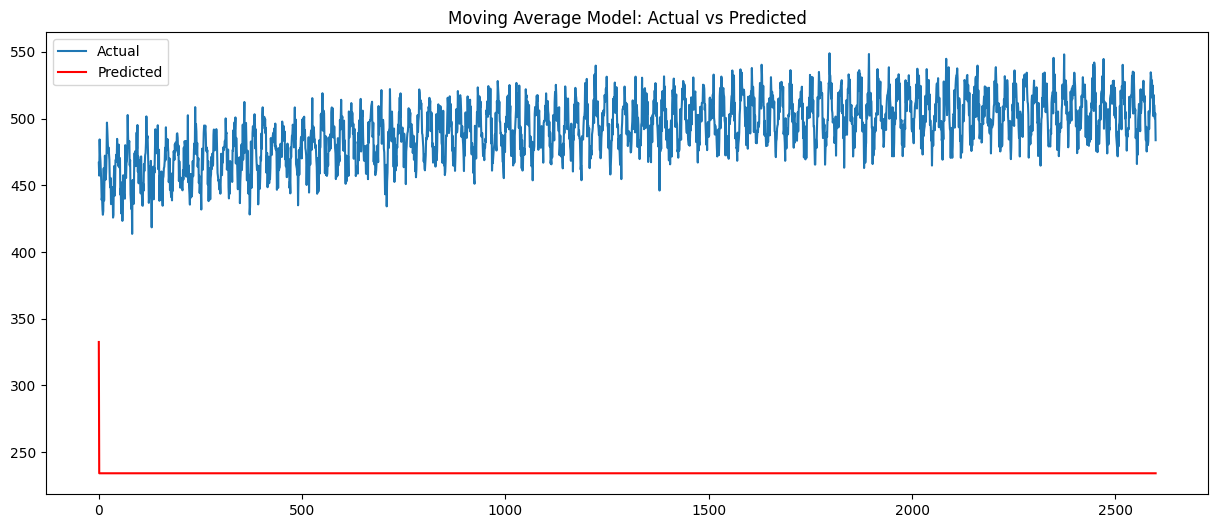

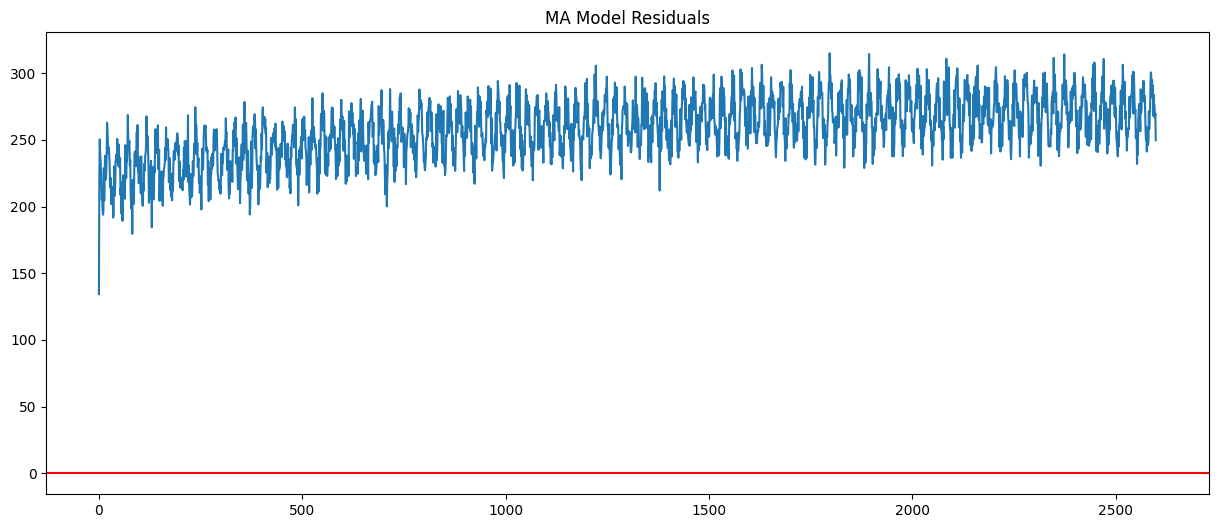

In [49]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare data
data = df['Drug_Demand'].values
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

# Train MA model (ARIMA with p=0, d=0, q=1)
model = ARIMA(train, order=(0, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.title('Moving Average Model: Actual vs Predicted')
plt.legend()
plt.show()

# Calculate and plot residuals
residuals = [test[i] - predictions[i] for i in range(len(predictions))]
plt.figure(figsize=(15, 6))
plt.plot(residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('MA Model Residuals')
plt.show()


# 16- ARIMA Model for Forecasting

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10400
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -41606.530
Date:                Fri, 11 Apr 2025   AIC                          83219.061
Time:                        12:44:50   BIC                          83240.809
Sample:                             0   HQIC                         83226.408
                              - 10400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2002      0.023     -8.592      0.000      -0.246      -0.155
ma.L1         -0.2355      0.024     -9.998      0.000      -0.282      -0.189
sigma2       174.8077      2.416     72.355      0.0

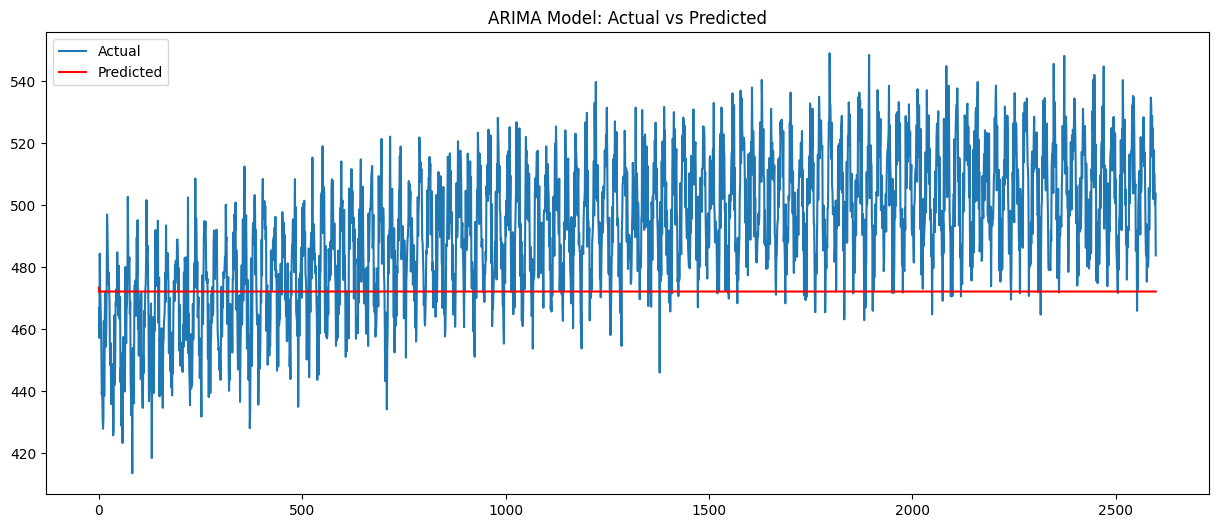

In [50]:
# Train ARIMA model (p=1, d=1, q=1)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.title('ARIMA Model: Actual vs Predicted')
plt.legend()
plt.show()


# 17- Autocorrelation and Partial Autocorrelation

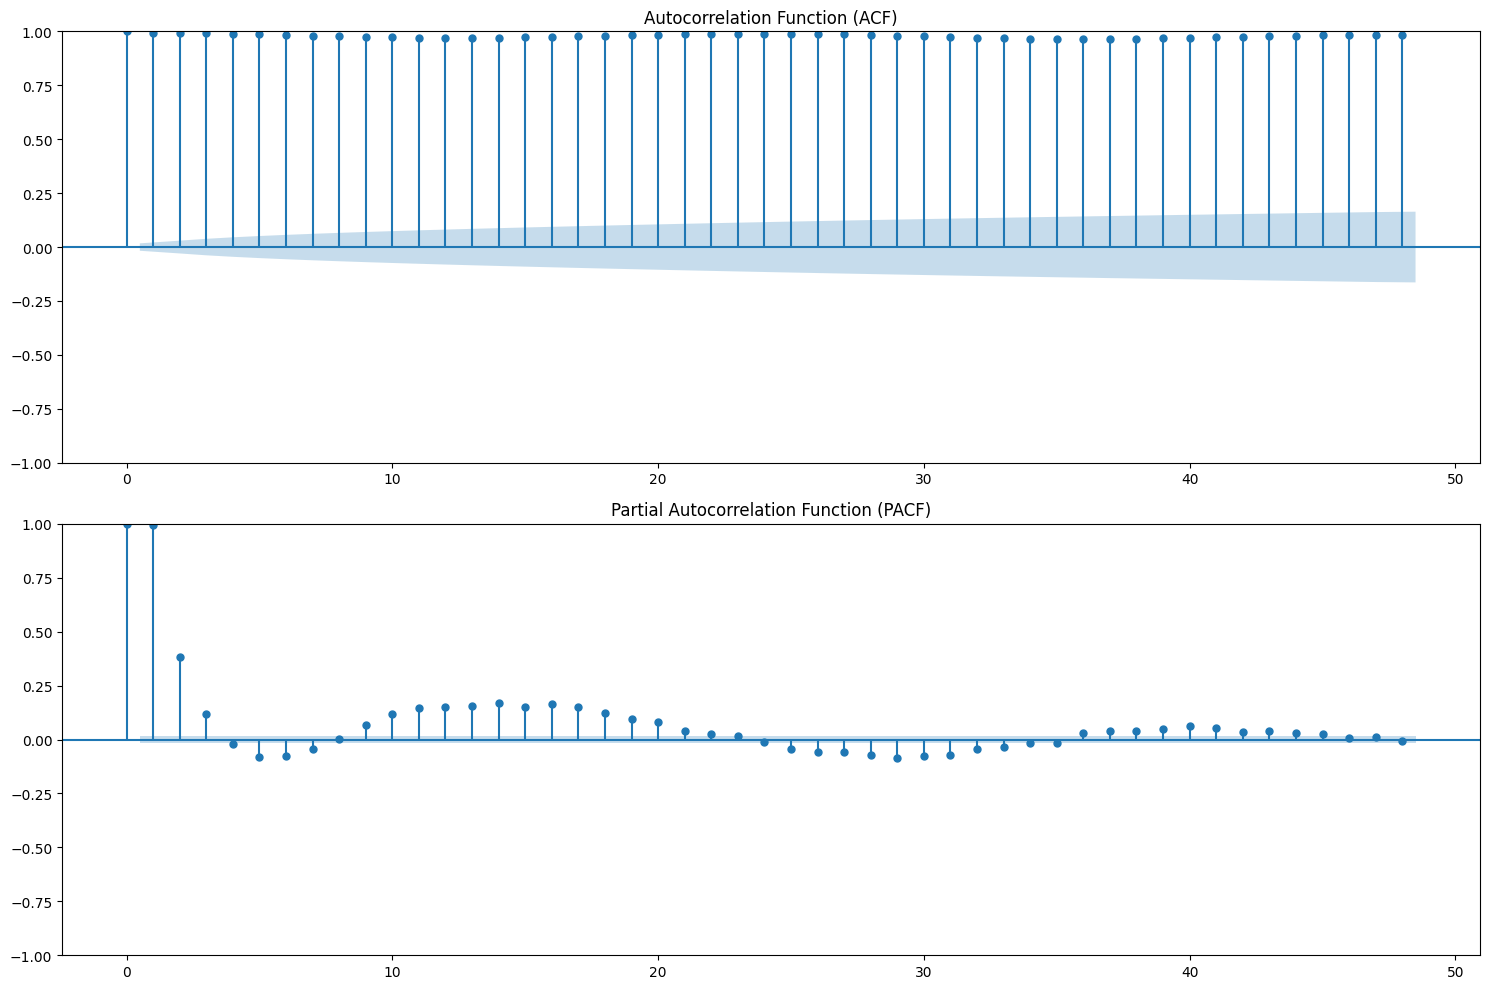

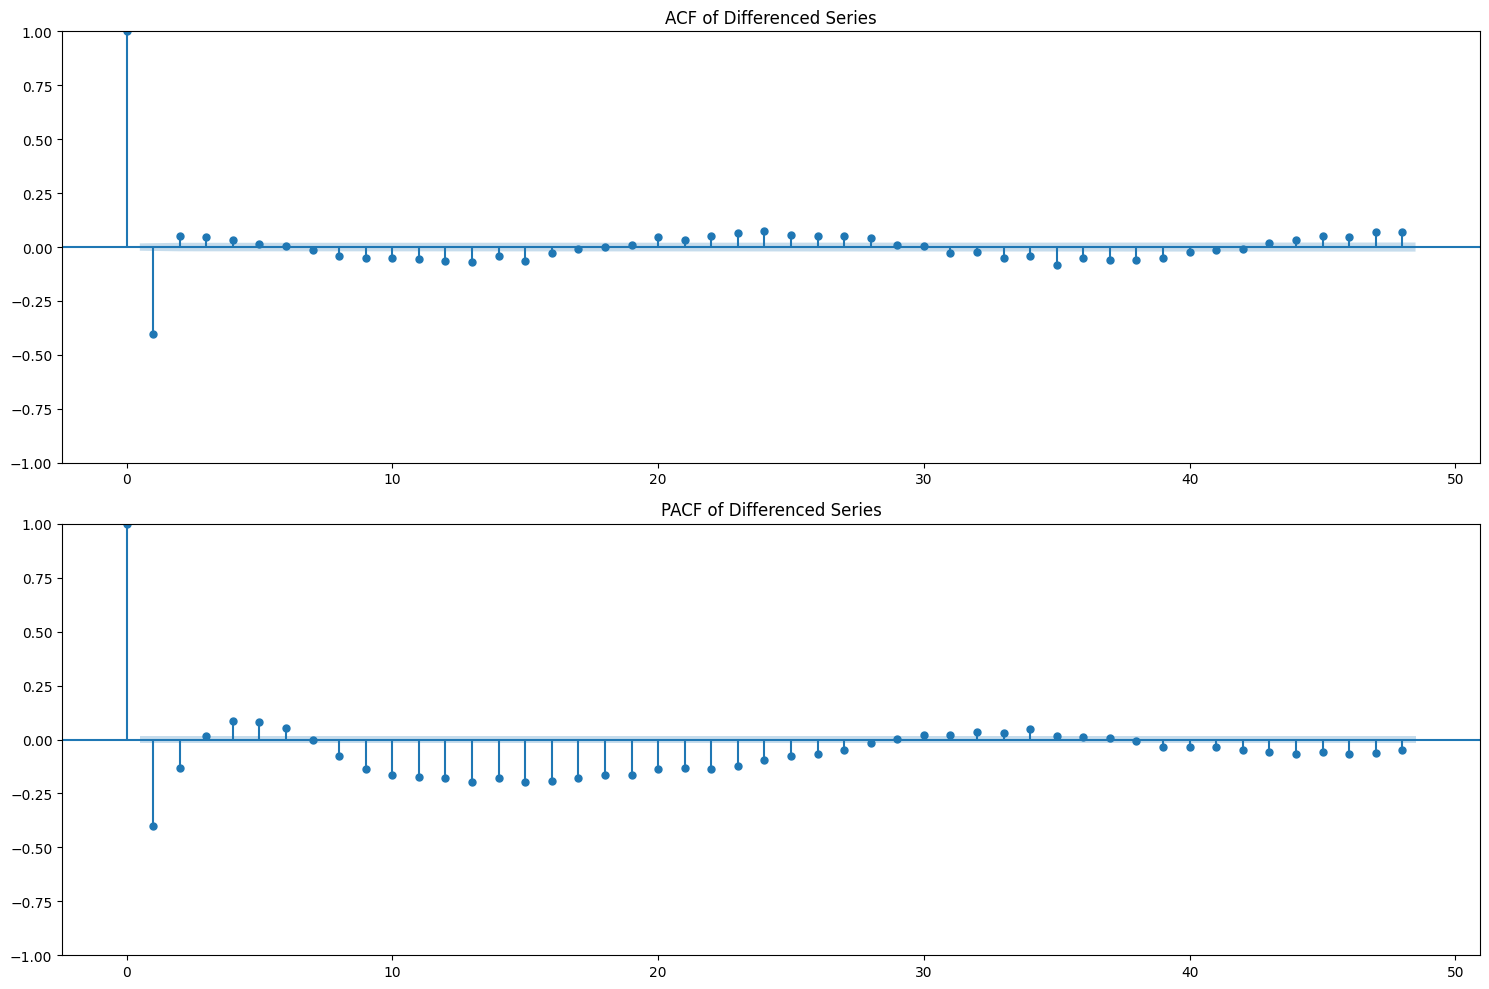

In [51]:
# Plot ACF and PACF
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plot_acf(df['Drug_Demand'].dropna(), lags=48, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(2, 1, 2)
plot_pacf(df['Drug_Demand'].dropna(), lags=48, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# Plot ACF and PACF for differenced series
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plot_acf(df['Drug_Demand_Diff'].dropna(), lags=48, ax=plt.gca())
plt.title('ACF of Differenced Series')

plt.subplot(2, 1, 2)
plot_pacf(df['Drug_Demand_Diff'].dropna(), lags=48, ax=plt.gca())
plt.title('PACF of Differenced Series')

plt.tight_layout()
plt.show()


# 18- Grid Search ARIMA Model Hyperparameters 

In [52]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import matplotlib.pyplot as plt

# Sample DataFrame (replace with your data)
dates = pd.date_range(start='2023-01-01', periods=100, freq='H')
data = np.random.randint(10, 50, size=100)
df = pd.DataFrame({'Drug_Demand': data}, index=dates)

# Define function to evaluate ARIMA model
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # Make predictions
    predictions = list()
    for t in range(len(test)):
        try:
            model = ARIMA(history, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])
        except:
            return float('inf')  # Return a large value if model fitting fails

    # Calculate out-of-sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# Evaluate combinations of p, d, and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    print(f'ARIMA{order} RMSE=%.3f' % rmse) #print each rmse value
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except:
                    print(f'ARIMA{order} failed to fit')
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg, best_score  

# Define parameter grid
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

# Evaluate models
warnings.filterwarnings("ignore")
best_order, arima_rmse = evaluate_models(df['Drug_Demand'].values, p_values, d_values, q_values)

# Train final model with best parameters
final_model = ARIMA(df['Drug_Demand'].values, order=best_order)
final_model_fit = final_model.fit()
print(final_model_fit.summary())

# Forecast future values (next 24 hours)
forecast = final_model_fit.forecast(steps=24)
forecast_index = pd.date_range(start=df.index[-1], periods=25, freq='H')[1:]


ARIMA(0, 0, 0) RMSE=12.356
ARIMA(0, 0, 1) RMSE=12.536
ARIMA(0, 0, 2) RMSE=12.849
ARIMA(0, 1, 0) RMSE=15.953
ARIMA(0, 1, 1) RMSE=12.407
ARIMA(0, 1, 2) RMSE=12.559
ARIMA(1, 0, 0) RMSE=12.491
ARIMA(1, 0, 1) RMSE=12.490
ARIMA(1, 0, 2) RMSE=12.585
ARIMA(1, 1, 0) RMSE=14.859
ARIMA(1, 1, 1) RMSE=12.527
ARIMA(1, 1, 2) RMSE=12.556
ARIMA(2, 0, 0) RMSE=12.504
ARIMA(2, 0, 1) RMSE=13.272
ARIMA(2, 0, 2) RMSE=13.395
ARIMA(2, 1, 0) RMSE=13.815
ARIMA(2, 1, 1) RMSE=12.549
ARIMA(2, 1, 2) RMSE=13.706
Best ARIMA(0, 0, 0) RMSE=12.356
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                          ARIMA   Log Likelihood                -386.112
Date:                Fri, 11 Apr 2025   AIC                            776.224
Time:                        12:48:55   BIC                            781.434
Sample:                             0   HQIC                           778.332
        

# 19- Resampling and Interpolation

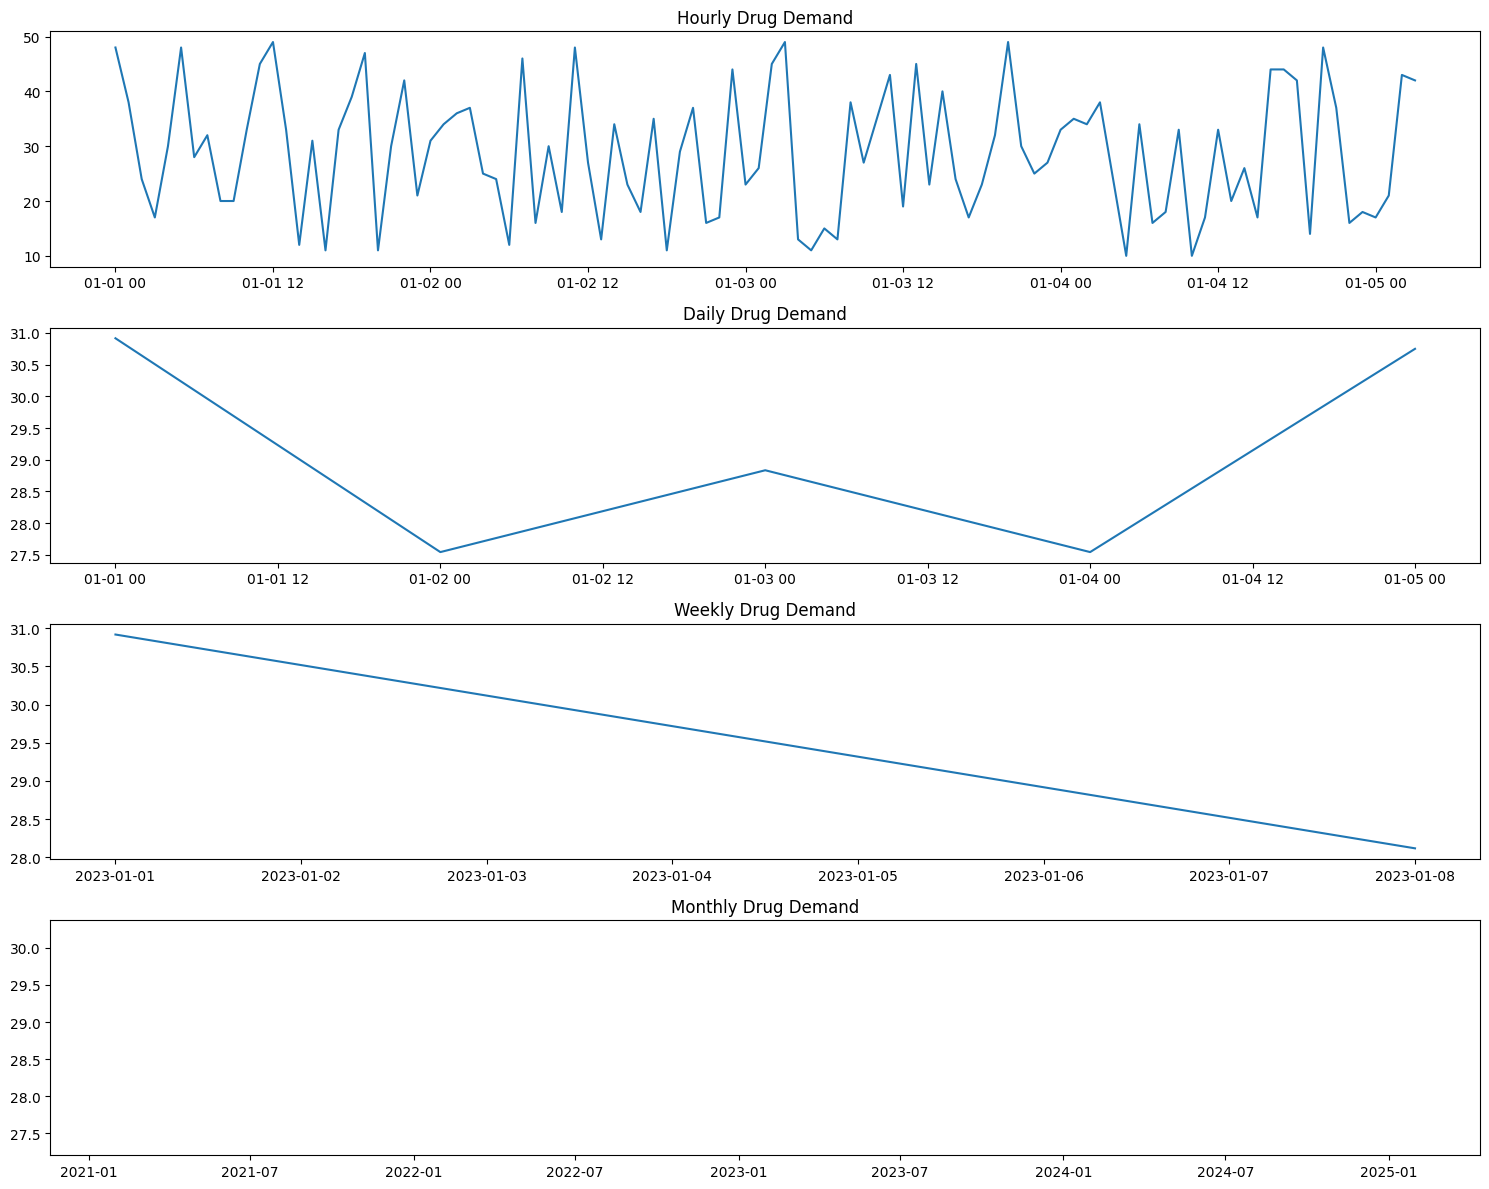

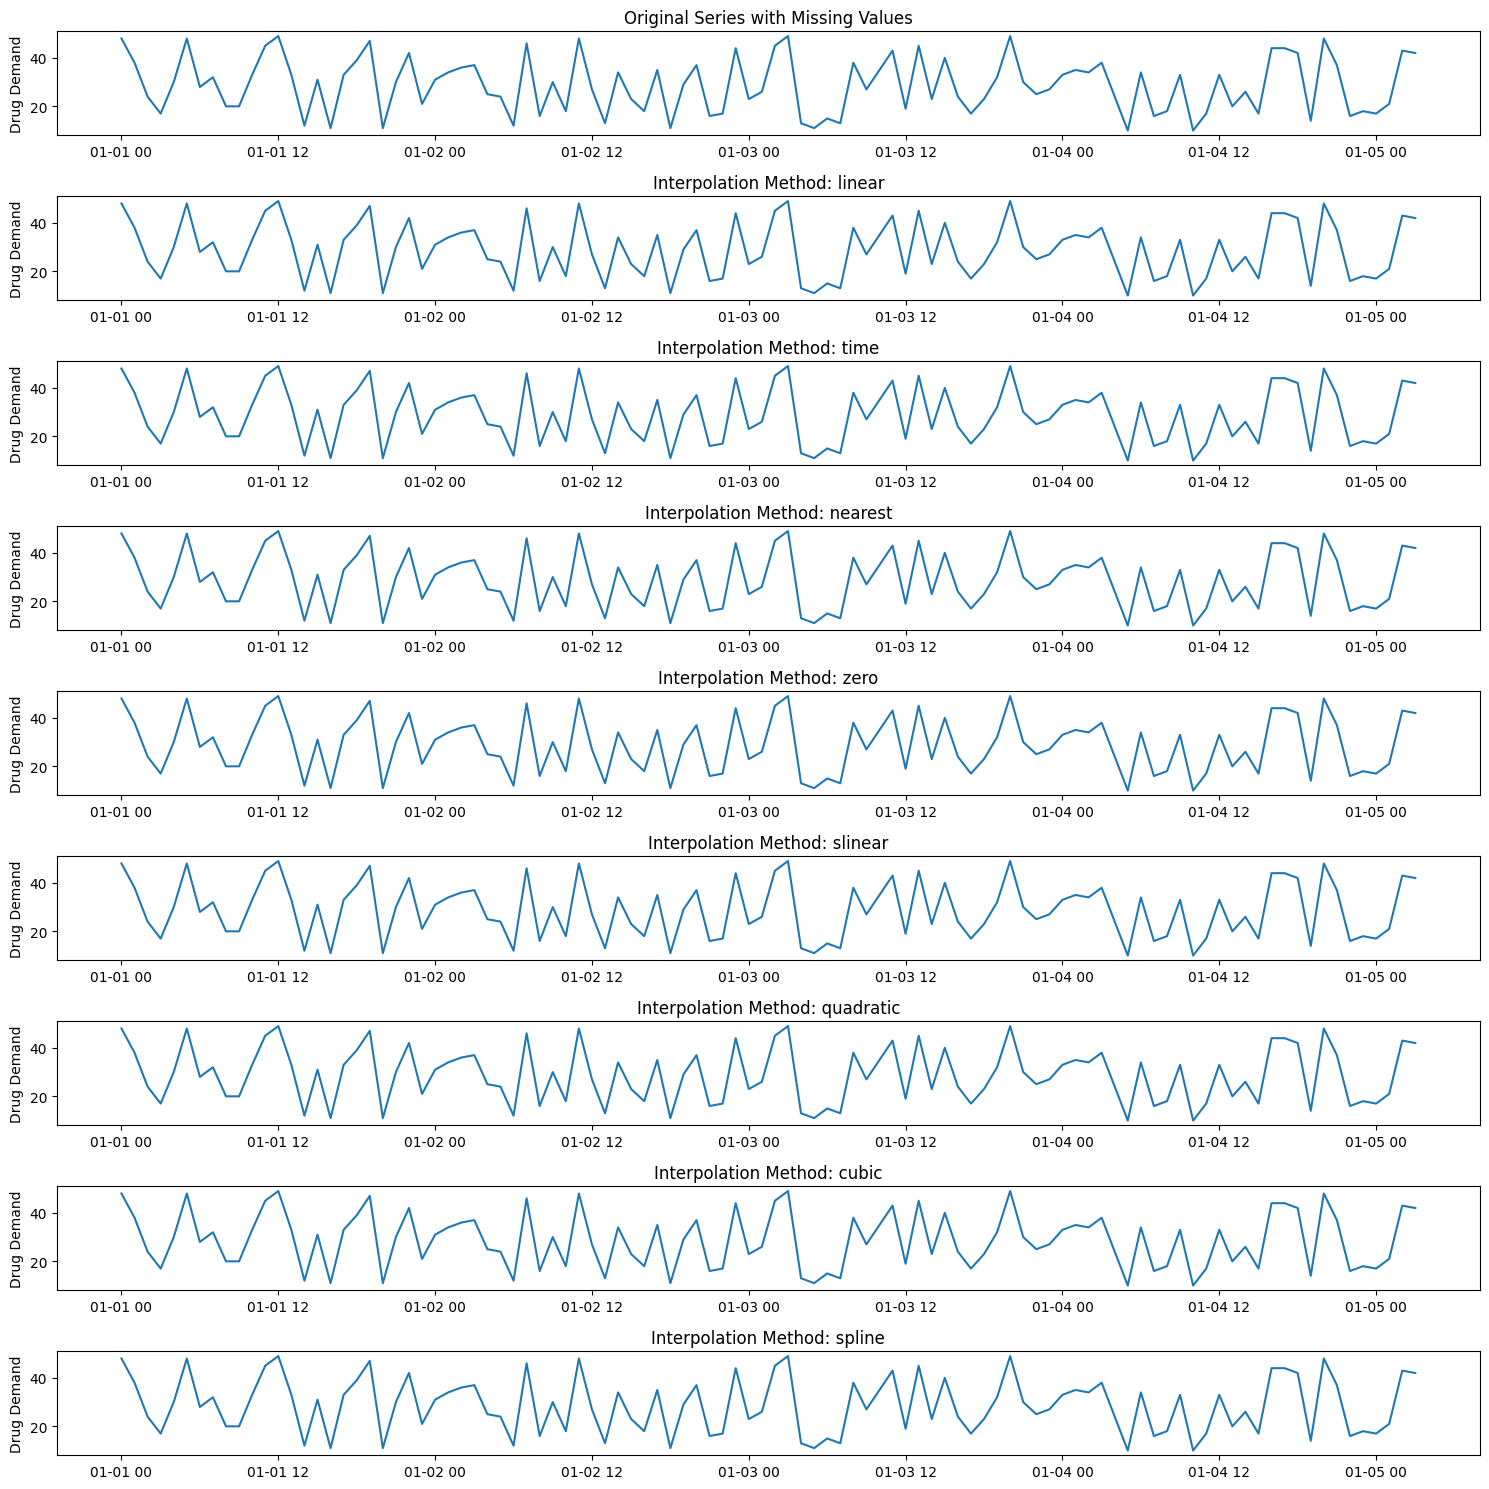

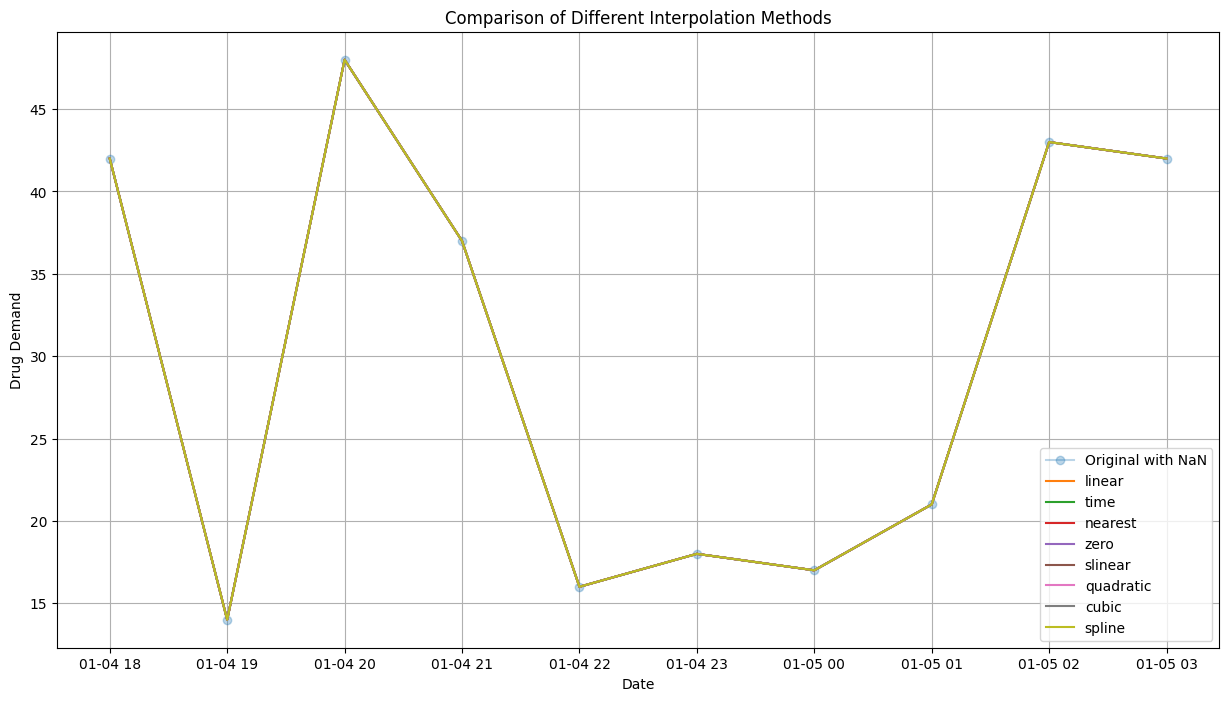

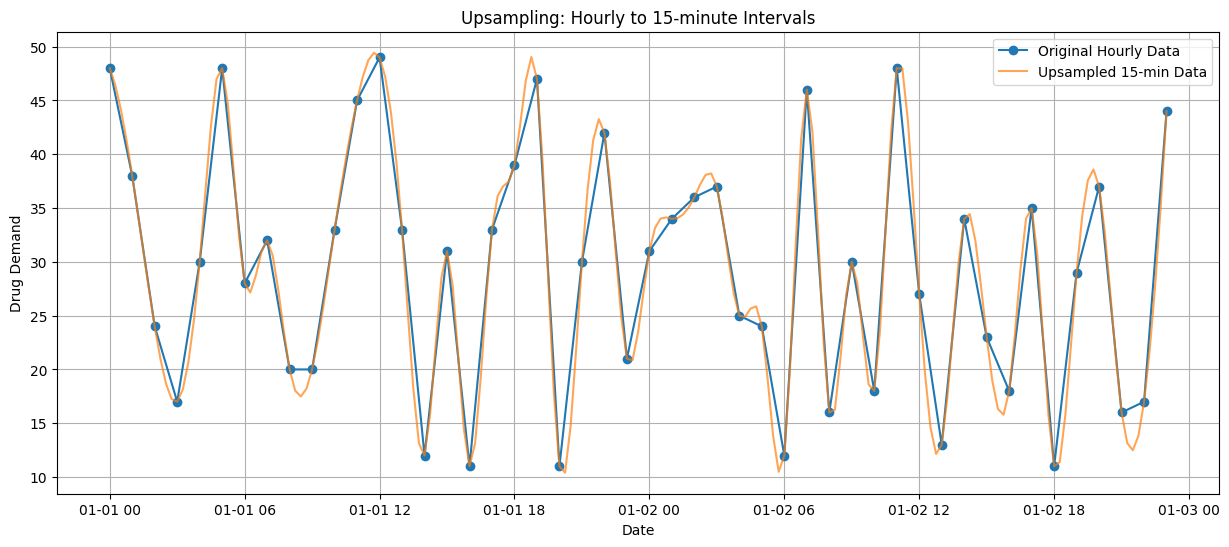

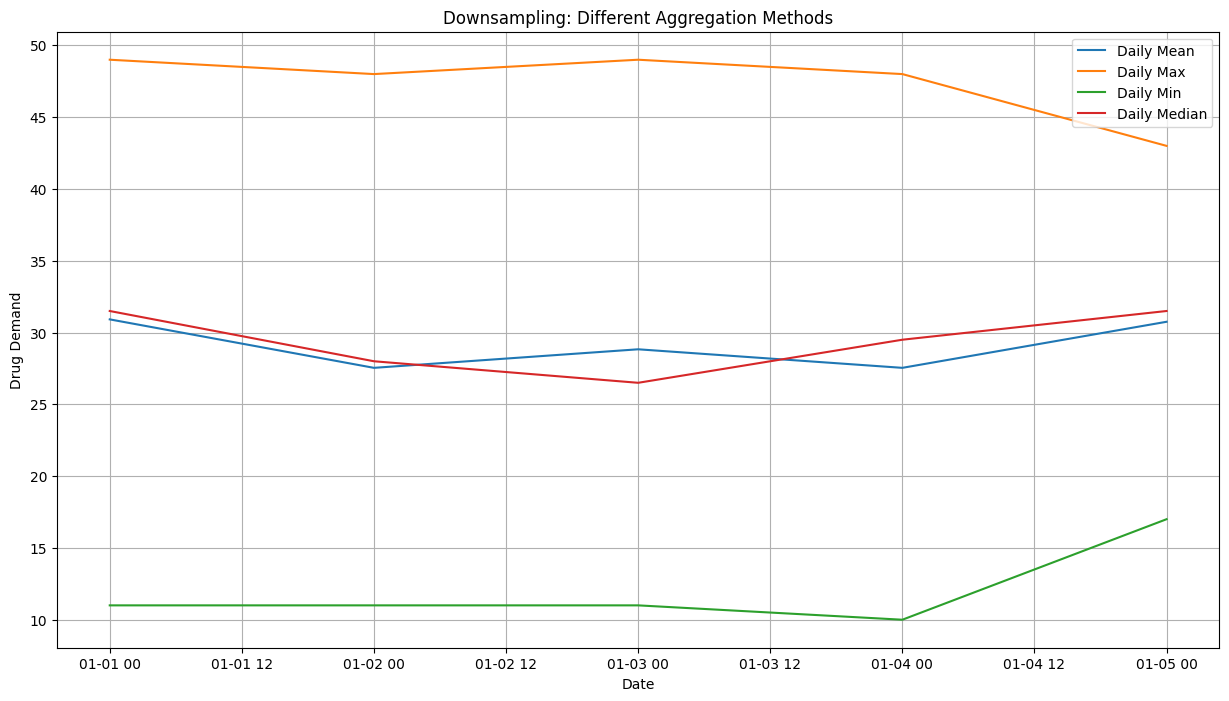

In [53]:
# Resample data to different frequencies
hourly = df['Drug_Demand'].resample('H').mean()
daily = df['Drug_Demand'].resample('D').mean()
weekly = df['Drug_Demand'].resample('W').mean()
monthly = df['Drug_Demand'].resample('M').mean()

# Plot the resampled data
plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
plt.plot(hourly)
plt.title('Hourly Drug Demand')

plt.subplot(4, 1, 2)
plt.plot(daily)
plt.title('Daily Drug Demand')

plt.subplot(4, 1, 3)
plt.plot(weekly)
plt.title('Weekly Drug Demand')

plt.subplot(4, 1, 4)
plt.plot(monthly)
plt.title('Monthly Drug Demand')

plt.tight_layout()
plt.show()

# Interpolation for missing values
# Create some missing values for demonstration
sample_series = df['Drug_Demand'].copy()
sample_series[100:120] = np.nan

# Different interpolation methods
methods = ['linear', 'time', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline']
plt.figure(figsize=(15, 15))

# Plot original series with missing values
plt.subplot(len(methods) + 1, 1, 1)
plt.plot(sample_series)
plt.title('Original Series with Missing Values')
plt.ylabel('Drug Demand')

# Plot each interpolation method
for i, method in enumerate(methods, 2):
    try:
        if method == 'spline':
            # Spline requires an order parameter
            interpolated = sample_series.interpolate(method='spline', order=3)
        else:
            interpolated = sample_series.interpolate(method=method)
        
        plt.subplot(len(methods) + 1, 1, i)
        plt.plot(interpolated)
        plt.title(f'Interpolation Method: {method}')
        plt.ylabel('Drug Demand')
    except Exception as e:
        print(f"Error with {method} interpolation: {e}")

plt.tight_layout()
plt.show()

# Compare different interpolation methods in a single plot
plt.figure(figsize=(15, 8))

# Plot the region with missing values
start_idx = max(0, 90)
end_idx = min(len(sample_series), 130)

plt.plot(sample_series.index[start_idx:end_idx], 
         sample_series.iloc[start_idx:end_idx], 
         'o-', label='Original with NaN', alpha=0.3)

# Plot each interpolation method
for method in methods:
    try:
        if method == 'spline':
            # Spline requires an order parameter
            interpolated = sample_series.interpolate(method='spline', order=3)
        else:
            interpolated = sample_series.interpolate(method=method)
        
        plt.plot(interpolated.index[start_idx:end_idx], 
                 interpolated.iloc[start_idx:end_idx], 
                 '-', label=method)
    except Exception as e:
        print(f"Error with {method} interpolation: {e}")

plt.title('Comparison of Different Interpolation Methods')
plt.xlabel('Date')
plt.ylabel('Drug Demand')
plt.legend()
plt.grid(True)
plt.show()

# Upsampling example (hourly to minute data)
# Take a small subset of the data for demonstration
subset = df['Drug_Demand'][:48]  # First 48 hours

# Upsample to 15-minute intervals
upsampled = subset.resample('15T').interpolate(method='cubic')

# Plot original vs upsampled data
plt.figure(figsize=(15, 6))
plt.plot(subset.index, subset.values, 'o-', label='Original Hourly Data')
plt.plot(upsampled.index, upsampled.values, '-', label='Upsampled 15-min Data', alpha=0.7)
plt.title('Upsampling: Hourly to 15-minute Intervals')
plt.xlabel('Date')
plt.ylabel('Drug Demand')
plt.legend()
plt.grid(True)
plt.show()

# Downsampling example with different aggregation methods
# Downsample hourly to daily with different aggregation methods
daily_mean = df['Drug_Demand'].resample('D').mean()
daily_max = df['Drug_Demand'].resample('D').max()
daily_min = df['Drug_Demand'].resample('D').min()
daily_median = df['Drug_Demand'].resample('D').median()

# Plot different aggregation methods
plt.figure(figsize=(15, 8))
plt.plot(daily_mean.index, daily_mean.values, '-', label='Daily Mean')
plt.plot(daily_max.index, daily_max.values, '-', label='Daily Max')
plt.plot(daily_min.index, daily_min.values, '-', label='Daily Min')
plt.plot(daily_median.index, daily_median.values, '-', label='Daily Median')
plt.title('Downsampling: Different Aggregation Methods')
plt.xlabel('Date')
plt.ylabel('Drug Demand')
plt.legend()
plt.grid(True)
plt.show()


# 20- Other models

### Prophet model

12:49:07 - cmdstanpy - INFO - Chain [1] start processing
12:49:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model RMSE: 17.302


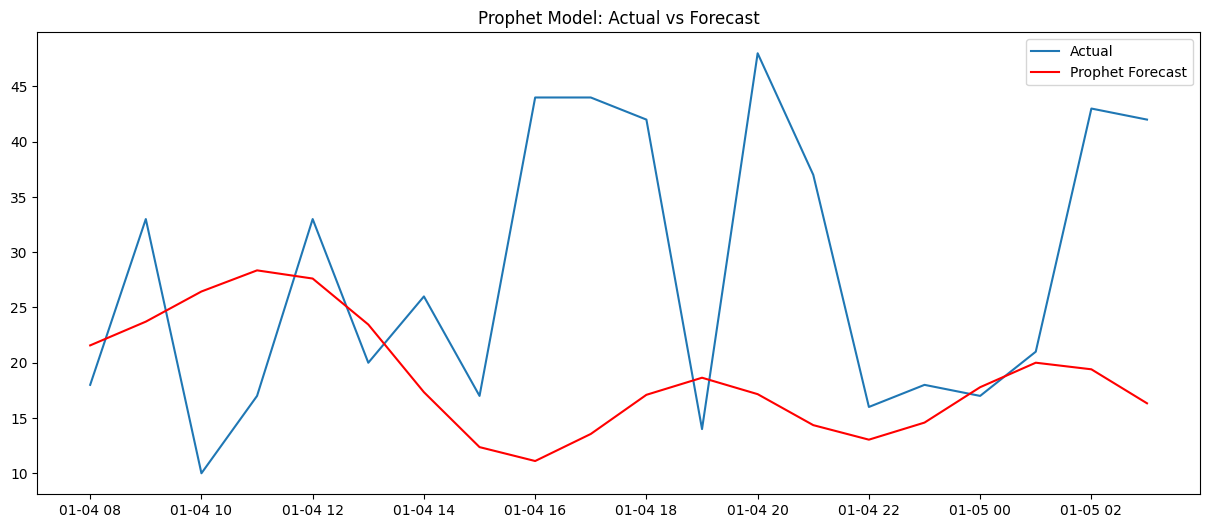

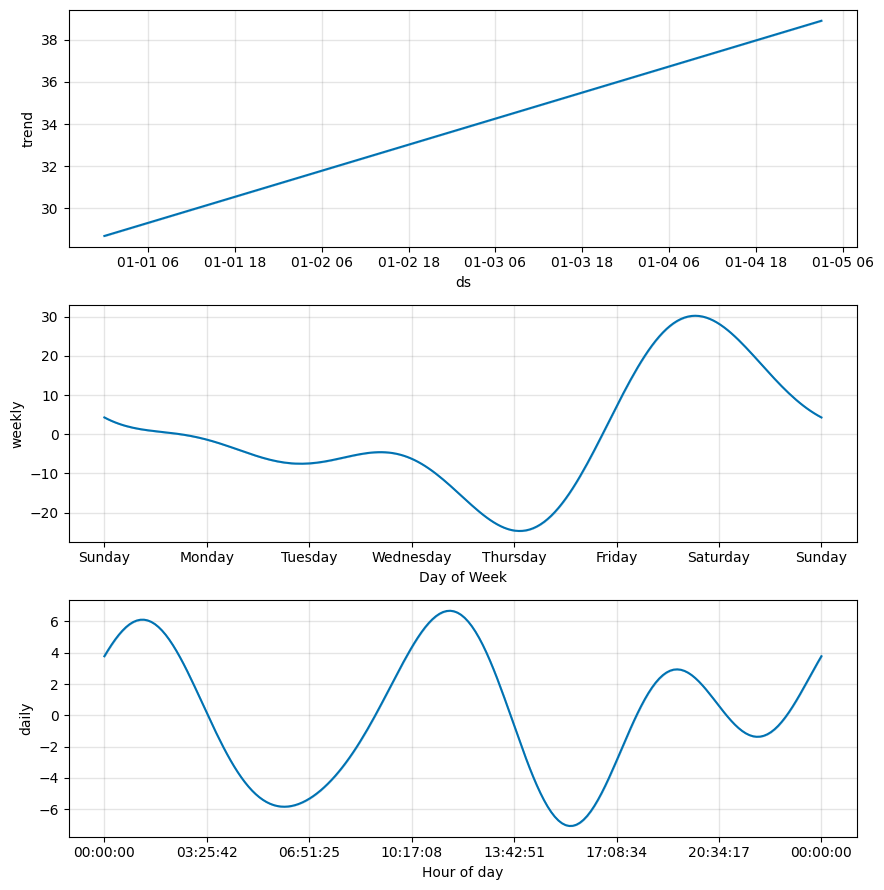

In [54]:
# Prophet model
from prophet import Prophet
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_df = pd.DataFrame({
    'ds': df.index,
    'y': df['Drug_Demand']
})

# Split into train and test
train_size = int(len(prophet_df) * 0.8)
train_prophet = prophet_df[:train_size]
test_prophet = prophet_df[train_size:]

# Create and fit the model
prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True)
prophet_model.fit(train_prophet)

# Create future dataframe for prediction period
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='H')

# Make predictions
forecast = prophet_model.predict(future)

# Extract predictions for test period
prophet_predictions = forecast['yhat'].iloc[-len(test_prophet):].values

# Calculate RMSE
prophet_rmse = sqrt(mean_squared_error(test_prophet['y'], prophet_predictions))
print(f'Prophet Model RMSE: {prophet_rmse:.3f}')

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual')
plt.plot(test_prophet['ds'], prophet_predictions, color='red', label='Prophet Forecast')
plt.title('Prophet Model: Actual vs Forecast')
plt.legend()
plt.show()

# Plot Prophet components
prophet_model.plot_components(forecast)
plt.show()


### SARIMA Model (Seasonal ARIMA)

                                     SARIMAX Results                                      
Dep. Variable:                        Drug_Demand   No. Observations:                   80
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood                -115.046
Date:                            Fri, 11 Apr 2025   AIC                            240.092
Time:                                    12:49:20   BIC                            246.929
Sample:                                01-01-2023   HQIC                           242.233
                                     - 01-04-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3780      0.242     -1.561      0.118      -0.853       0.096
ma.L1         -1.0001    125.406   

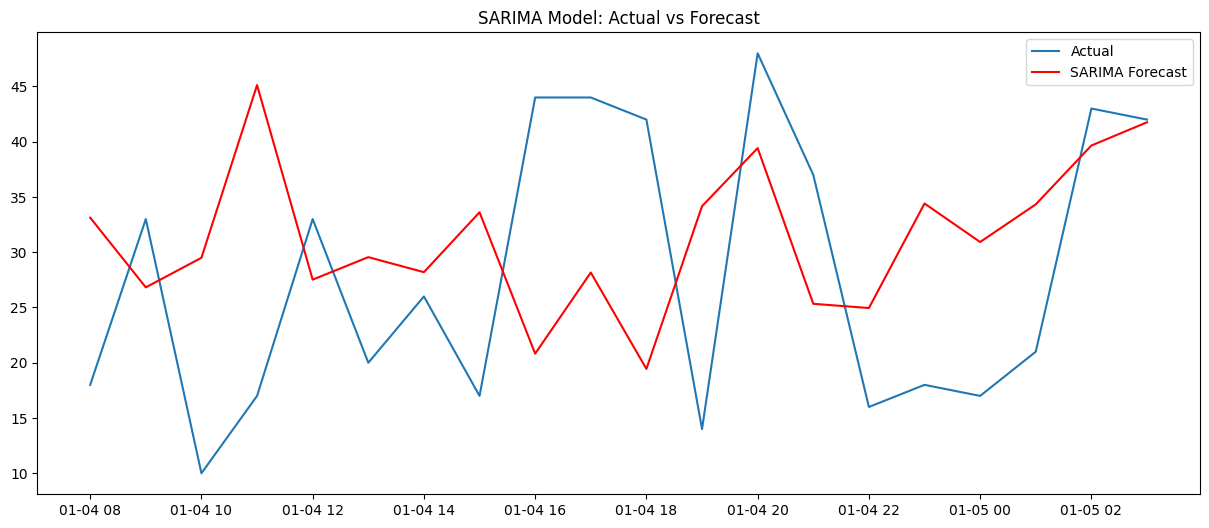

In [55]:
# SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Prepare data
train_size = int(len(df) * 0.8)
train, test = df['Drug_Demand'][:train_size], df['Drug_Demand'][train_size:]

# Define and fit SARIMA model - (p,d,q)x(P,D,Q,s)
# Using parameters for daily seasonality (s=24)
sarima_model = SARIMAX(train, 
                      order=(1, 1, 1),
                      seasonal_order=(1, 1, 1, 24),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
sarima_results = sarima_model.fit(disp=False)
print(sarima_results.summary())

# Forecast
sarima_forecast = sarima_results.forecast(steps=len(test))

# Calculate RMSE
sarima_rmse = sqrt(mean_squared_error(test, sarima_forecast))
print(f'SARIMA Model RMSE: {sarima_rmse:.3f}')

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, sarima_forecast, color='red', label='SARIMA Forecast')
plt.title('SARIMA Model: Actual vs Forecast')
plt.legend()
plt.show()


### 3- Random Forest Regressor

Random Forest RMSE: 12.476


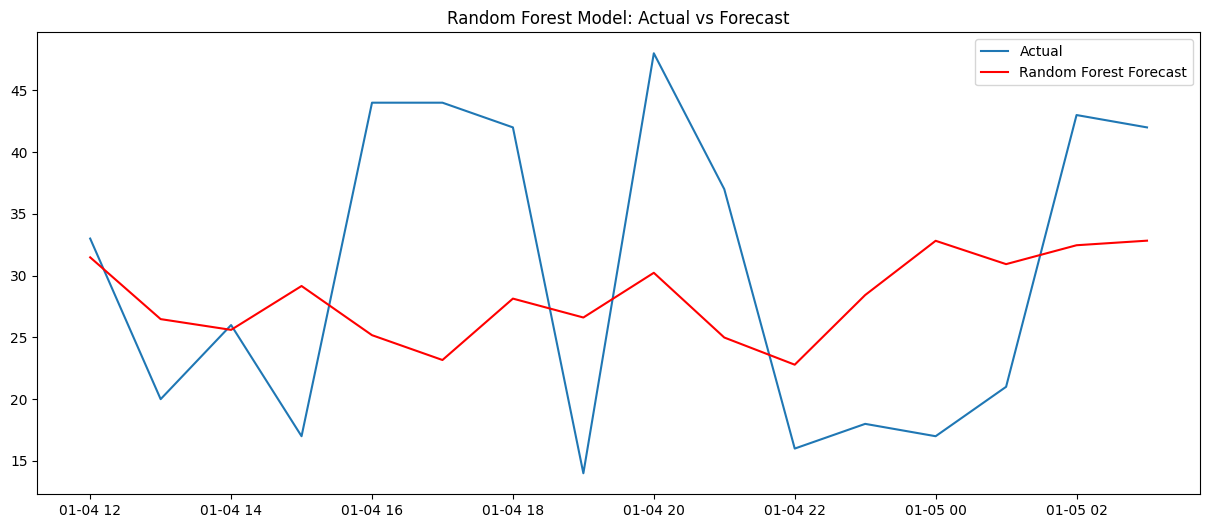

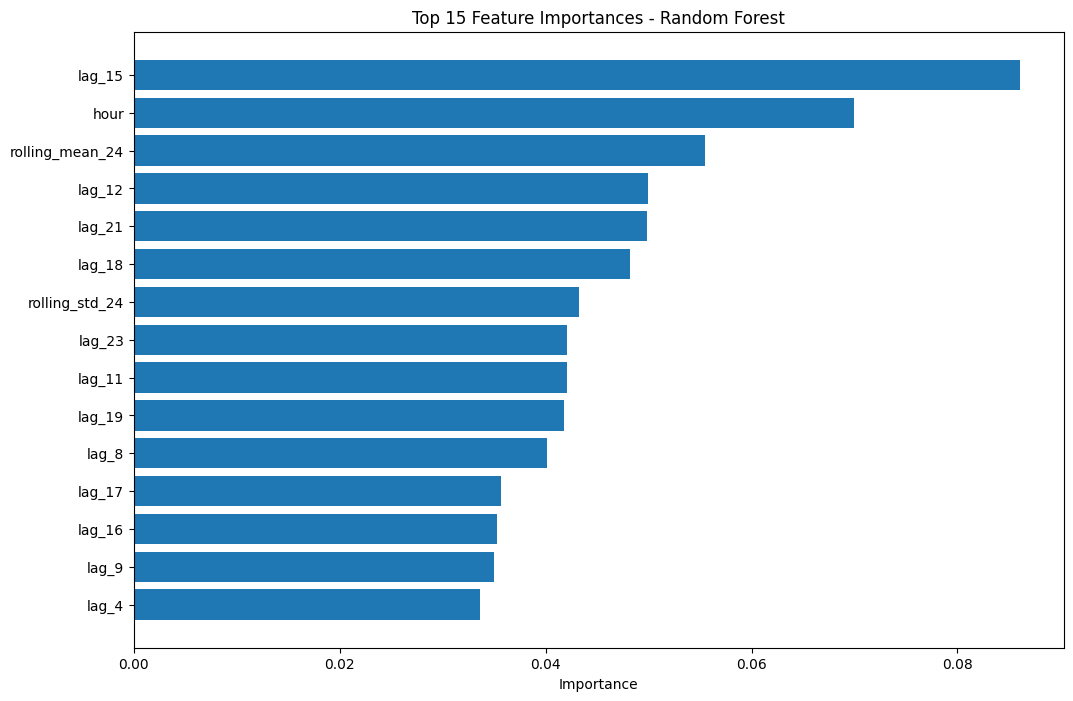

In [56]:
# Random Forest model
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Create time-based features from the index
X = pd.DataFrame(index=df.index)
X['hour'] = df.index.hour
X['day'] = df.index.day
X['weekday'] = df.index.weekday
X['month'] = df.index.month
X['year'] = df.index.year

# Add lag features
for i in range(1, 25):  # 24 hour lags
    X[f'lag_{i}'] = df['Drug_Demand'].shift(i)
    
# Add rolling features
X['rolling_mean_24'] = df['Drug_Demand'].rolling(window=24).mean()
X['rolling_std_24'] = df['Drug_Demand'].rolling(window=24).std()

# Drop rows with NaN (due to lag creation)
X = X.dropna()
y = df['Drug_Demand'].loc[X.index]

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create and fit the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Calculate RMSE
rf_rmse = sqrt(mean_squared_error(y_test, rf_predictions))
print(f'Random Forest RMSE: {rf_rmse:.3f}')

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, rf_predictions, color='red', label='Random Forest Forecast')
plt.title('Random Forest Model: Actual vs Forecast')
plt.legend()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15])
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()


### 4- XGBoost Regressor

XGBoost RMSE: 13.223


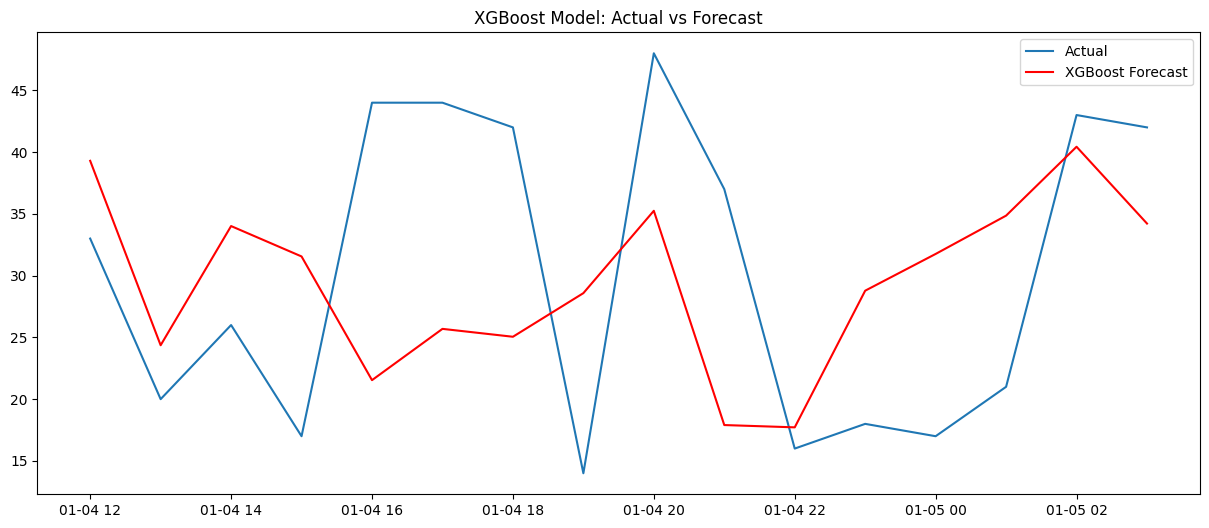

In [ ]:
# XGBoost model
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Use the same features as Random Forest
# Create time-based features from the index
X = pd.DataFrame(index=df.index)
X['hour'] = df.index.hour
X['day'] = df.index.day
X['weekday'] = df.index.weekday
X['month'] = df.index.month
X['year'] = df.index.year

# Add lag features
for i in range(1, 25):  # 24 hour lags
    X[f'lag_{i}'] = df['Drug_Demand'].shift(i)
    
# Add rolling features
X['rolling_mean_24'] = df['Drug_Demand'].rolling(window=24).mean()
X['rolling_std_24'] = df['Drug_Demand'].rolling(window=24).std()

# Drop rows with NaN (due to lag creation)
X = X.dropna()
y = df['Drug_Demand'].loc[X.index]

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create and fit the model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_predictions = xgb_model.predict(X_test)

# Calculate RMSE
xgb_rmse = sqrt(mean_squared_error(y_test, xgb_predictions))
print(f'XGBoost RMSE: {xgb_rmse:.3f}')

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, xgb_predictions, color='red', label='XGBoost Forecast')
plt.title('XGBoost Model: Actual vs Forecast')
plt.legend()
plt.show()

# Feature importance
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(xgb_importance['Feature'][:15], xgb_importance['Importance'][:15])
plt.title('Top 15 Feature Importances - XGBoost')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()


### 5- LSTM Neural Network

In [ ]:
# LSTM model with 20 epochs
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Scale the data - using a robust scaler range
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Drug_Demand'].values.reshape(-1, 1))

# Create sequences with more features
def create_sequences_with_features(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Basic sequence
        seq = data[i:i + seq_length, 0]
        
        # Add engineered features
        seq_mean = np.mean(seq)
        seq_std = np.std(seq)
        seq_min = np.min(seq)
        seq_max = np.max(seq)
        seq_trend = seq[-1] - seq[0]  # Simple trend
        
        # Combine all features
        features = np.column_stack((
            seq,
            np.ones(seq_length) * seq_mean,
            np.ones(seq_length) * seq_std,
            np.ones(seq_length) * seq_min,
            np.ones(seq_length) * seq_max,
            np.ones(seq_length) * seq_trend
        ))
        
        X.append(features)
        y.append(data[i + seq_length, 0])
    
    return np.array(X), np.array(y)

# Use 24 hours of history to predict the next hour
seq_length = 24
X, y = create_sequences_with_features(scaled_data, seq_length)

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build an improved LSTM model
model = Sequential()

# First Bidirectional LSTM layer with more units
model.add(Bidirectional(LSTM(100, return_sequences=True), 
                        input_shape=(seq_length, X.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third LSTM layer
model.add(LSTM(50))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1))

# Compile with a custom learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Callbacks for better training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Reduced patience since we have fewer epochs
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,  # Reduced patience since we have fewer epochs
    min_lr=0.0001,
    verbose=1
)

# Train the model with 20 epochs
history = model.fit(
    X_train, y_train,
    epochs=20,  # Reduced to 20 epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Make predictions
lstm_predictions = model.predict(X_test)

# Inverse transform to original scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Calculate RMSE
lstm_rmse = sqrt(mean_squared_error(y_test_inv, lstm_predictions))
print(f'LSTM Model RMSE: {lstm_rmse:.3f}')

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(lstm_predictions, color='red', label='LSTM Forecast')
plt.title('Enhanced LSTM Model: Actual vs Forecast')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 6- Exponential Smoothing (ETS)

In [ ]:
# Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Prepare data
train_size = int(len(df) * 0.8)
train, test = df['Drug_Demand'][:train_size], df['Drug_Demand'][train_size:]

# Create and fit ETS model with daily seasonality
ets_model = ExponentialSmoothing(
    train,
    seasonal_periods=24,  # Daily seasonality
    trend='add',
    seasonal='add',
    use_boxcox=True
)
ets_fit = ets_model.fit()

# Forecast
ets_forecast = ets_fit.forecast(len(test))

# Calculate RMSE
ets_rmse = sqrt(mean_squared_error(test, ets_forecast))
print(f'ETS Model RMSE: {ets_rmse:.3f}')

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, ets_forecast, color='red', label='ETS Forecast')
plt.title('Exponential Smoothing: Actual vs Forecast')
plt.legend()
plt.show()


###  Model Comparison

In [ ]:
# Compare all models
import pandas as pd
import matplotlib.pyplot as plt

models = {
    'ARIMA': arima_rmse,
    'SARIMA': sarima_rmse,
    'Prophet': prophet_rmse,
    'Random Forest': rf_rmse,
    'XGBoost': xgb_rmse,
    'LSTM': lstm_rmse,
    'ETS': ets_rmse
}

# Create comparison bar chart
plt.figure(figsize=(12, 8))
plt.bar(models.keys(), models.values())
plt.title('Model Comparison - RMSE (lower is better)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

# Add values on top of bars
for i, (model, rmse) in enumerate(models.items()):
    plt.text(i, rmse + 0.01, f'{rmse:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Create a comparison table
comparison_df = pd.DataFrame({
    'Model': models.keys(),
    'RMSE': models.values()
}).sort_values('RMSE')

print("Model Performance Comparison:")
print(comparison_df)

# Print the best model and its RMSE
best_model = comparison_df.iloc[0]
print(f"\nConclusion: The best model performance is '{best_model['Model']}' with an RMSE of {best_model['RMSE']:.3f}")
